In [1]:
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
from collections import Counter, defaultdict, OrderedDict
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
def get_assigned_params(molecule, forcefield):
    """
    takes an offmol and forcefield as input and returns the unique set of torsion params assigned
    
    """
    topology = Topology.from_molecules(molecule)
    molecule_force_list = forcefield.label_molecules(topology)
    params = []
    # Print out a formatted description of the parameters applied to this molecule
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        for force_tag, force_dict in mol_forces.items():
            if force_tag == "ProperTorsions":
                for (atom_indices, parameter) in force_dict.items():
                        params.append(parameter.id)
    return set(params)


# Reading the pickle file of benchmark run with 1.2.0 and 1.3.0

In [3]:
pickle_file_path = './off_120_130_benchmark_plots/metrics.pickle'
enes_full, rmsds_full, tfds_full, smiles_full = pickle.load(open(pickle_file_path, "rb"))
ff_list = ['openff_unconstrained-1.2.0', 'openff_unconstrained-1.3.0']
num_ffs = len(smiles_full)         # dimesion1: no. of forcefields in this pickle file
num_mols = len(smiles_full[0])     # dimension2: no. of molecules
num_confs = len(smiles_full[0][0]) # dimension3: no. of conformers
print(num_ffs, num_mols, num_confs)
# a 3-dimensional array 
# num_ffs = 2: [openff-1.2.0, openff-1.3.0]
# num_mols = 3093: number of unique molecules
# num_confs = 10: supposedly upto 10 conformers for each molecule


2 3093 10


# Finding overrepresented parameters in the larger discrepancy molecules wrt Openff-1.3.0 optimized geometries

In [4]:
dde_off130 = []
rmsd_off130 = []
tfd_off130 = []

# iterating over the molecules list and taking the mean values of resepctive metrics for all conformers within a molecule
# first index=1 corresponds to openff_unconstrained-1.3.0 in the pickle file
# (another approach can be instead of taking the mean picking the maximum value of metric among conformers in each molecule)
for j in range(num_mols):
    dde_off130.append(np.mean(enes_full[1][j][:]))
    rmsd_off130.append(np.mean(rmsds_full[1][j][:]))
    tfd_off130.append(np.mean(tfds_full[1][j][:]))
    

smiles_list = np.array(smiles_full[1][:])

# lists of mols
large_dde_mols = []
large_rmsd_mols = []
large_tfd_mols = []

# dicts of parameters
params_dde_subset = defaultdict(float)
params_rmsd_subset = defaultdict(float)
params_tfd_subset = defaultdict(float)
params_full = defaultdict(float)

# For openff-1.3.0
ff = ForceField('openff_unconstrained-1.3.0.offxml')

for i in tqdm(range(num_mols)):
    #taking the smiles of the first conformer
    smiles_str = smiles_list[i][0]
    smiles_str = smiles_str[:-2]
    
    #getting the unique set of assigned torsion parameters
    mol = Molecule.from_smiles(smiles_str, allow_undefined_stereo=True)
    assigned_params = get_assigned_params(mol, ff)
    for item in assigned_params:
        params_full[item] += 1
        
    # the following thresholds are a bit arbitrary just to capture the tail end molecules in the distributions
    # can change them
    
    # capturing the total number of mols matching a particular parameter
    # if a parameter is present in the set of assigned torsions the value is incremented 
    # for that torsion parameter id key in the dicts
    
    
    # if the dde is greater than 5.0 kcal/mol considering it as large discrepancy
    if abs(dde_off130[i]) > 5.0:
        large_dde_mols.append(mol)
        for item in assigned_params:
            params_dde_subset[item] += 1
    
    # if the rmsd is greater than 1.0 angstrom considering it as large discrepancy
    if abs(rmsd_off130[i]) > 1.0:
        large_rmsd_mols.append(mol)
        for item in assigned_params:
            params_rmsd_subset[item] += 1
        
    # if the tfd is greater than 0.1 considering it as large discrepancy
    if abs(tfd_off130[i]) > 0.1:
        large_tfd_mols.append(mol)
        for item in assigned_params:
            params_tfd_subset[item] += 1
    
    
# in the whole benchmark set fraction of mols matching each parameter
for key, value in params_full.items():
    params_full[key] = value/num_mols
    
# in the subset of larger discrepancy molecules fraction of mols matching each parameter
for key, value in params_dde_subset.items():
    params_dde_subset[key] = value/len(large_dde_mols)

for key, value in params_rmsd_subset.items():
    params_rmsd_subset[key] = value/len(large_rmsd_mols)

for key, value in params_tfd_subset.items():
    params_tfd_subset[key] = value/len(large_tfd_mols)

<ipython-input-4-822c3be87a9d>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  smiles_list = np.array(smiles_full[1][:])
100%|██████████| 3093/3093 [09:58<00:00,  5.17it/s]


In [5]:
print('Large dde, > 5 kcal/mol: ', len(large_dde_mols), 'mols')
print('Large RMSD, > 1 Angstrom ', len(large_rmsd_mols), 'mols')
print('Large TFD, > 0.1 ', len(large_tfd_mols), 'mols')

Large dde, > 5 kcal/mol:  56 mols
Large RMSD, > 1 Angstrom  56 mols
Large TFD, > 0.1  410 mols


Large dde, > 5 kcal/mol:  56 mols


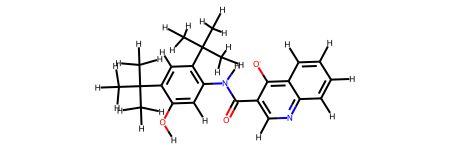

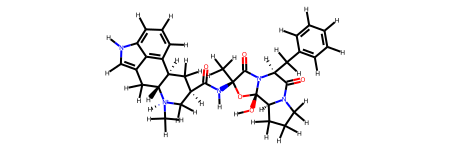

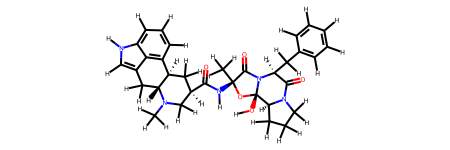

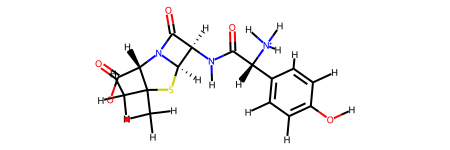

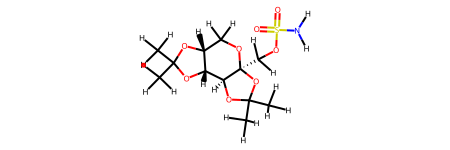

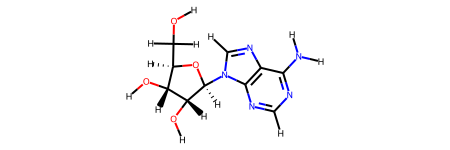

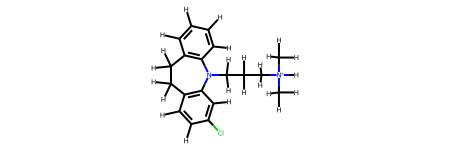

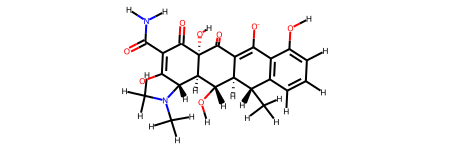

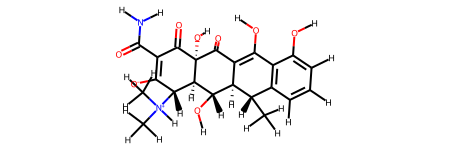

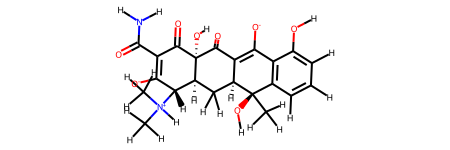

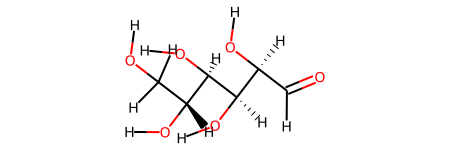

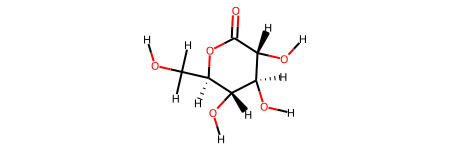

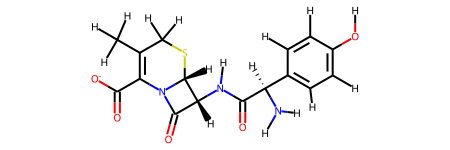

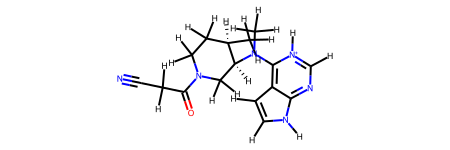

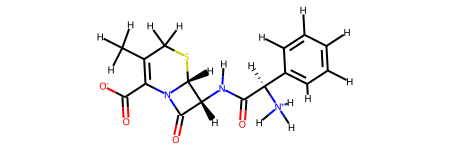

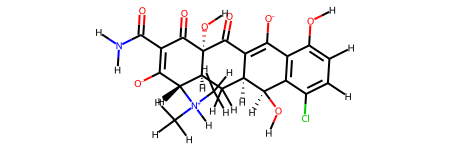

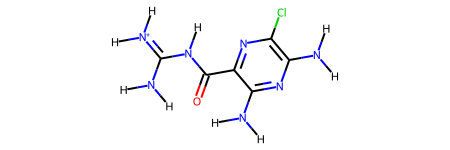

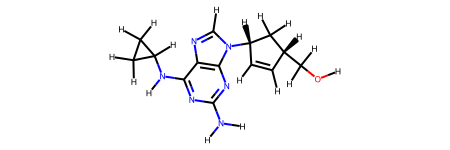

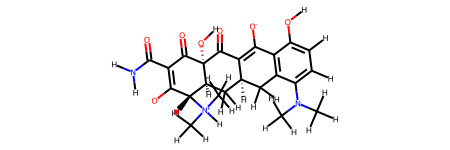

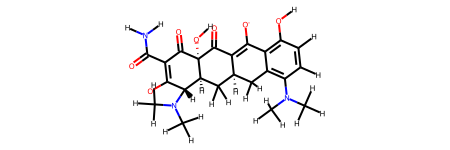

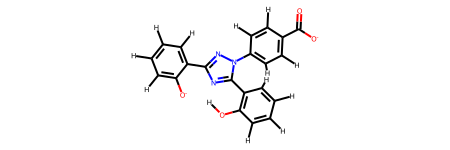

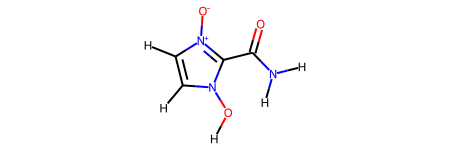

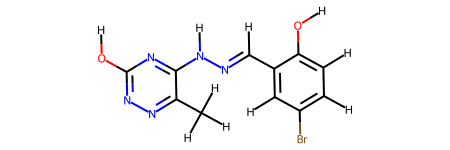

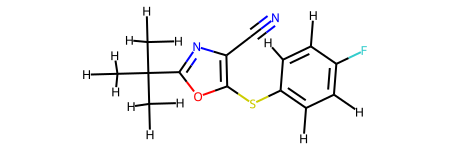

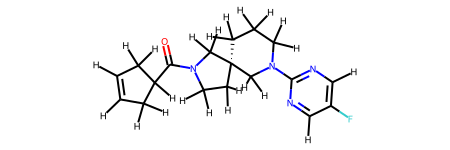

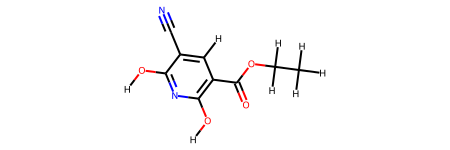

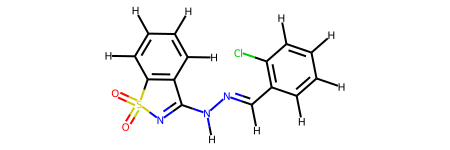

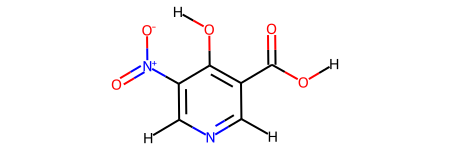

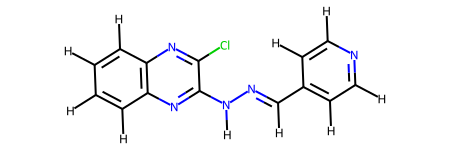

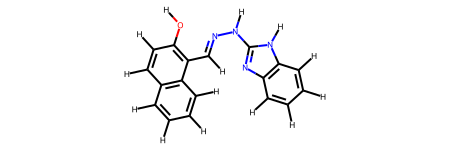

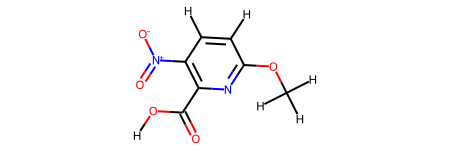

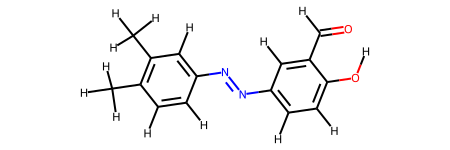

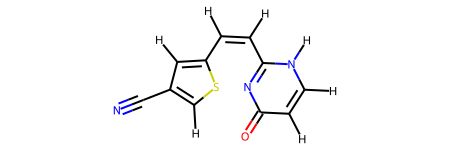

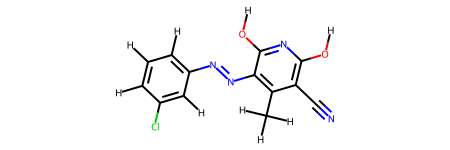

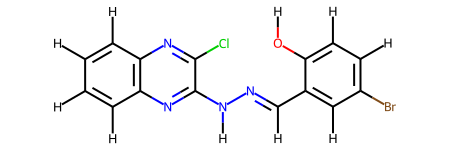

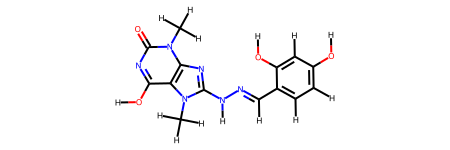

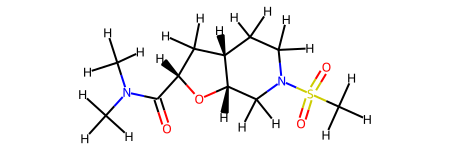

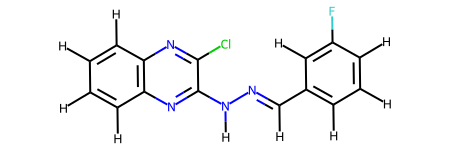

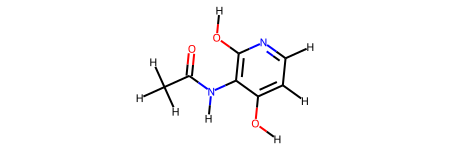

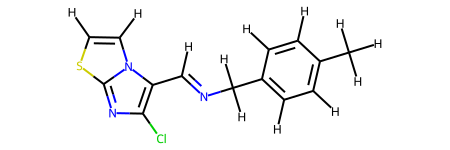

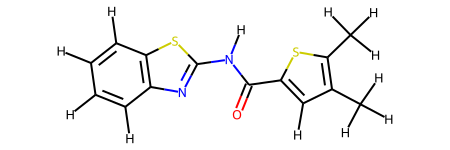

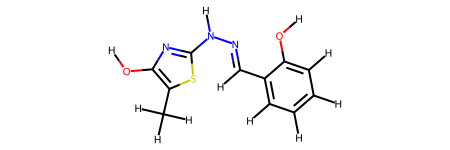

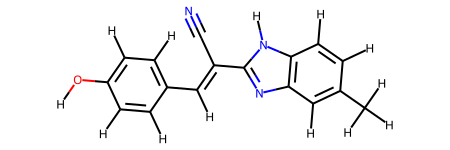

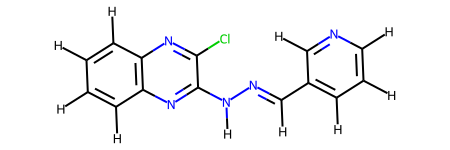

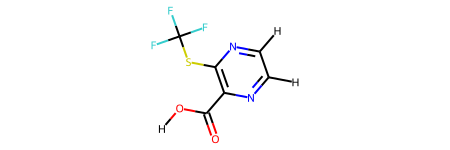

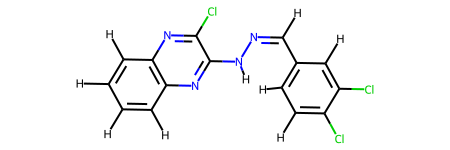

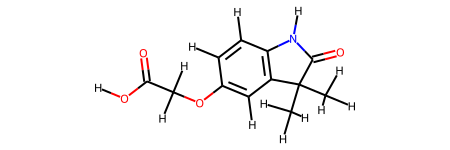

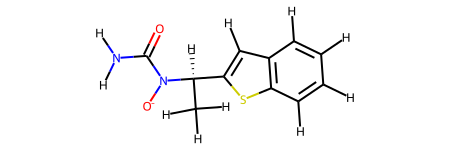

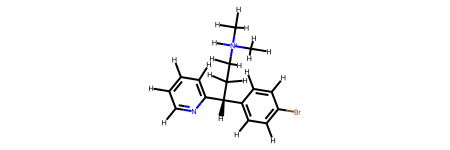

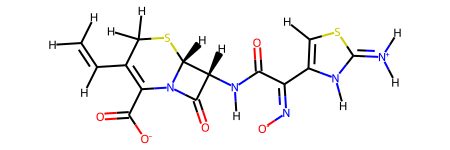

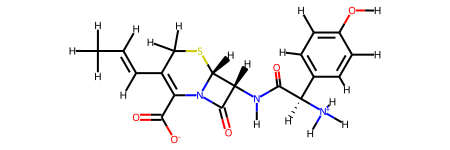

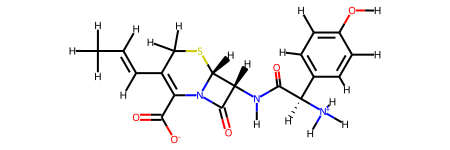

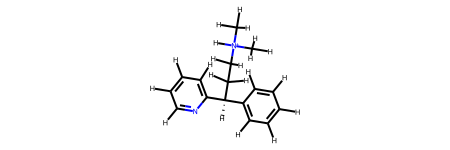

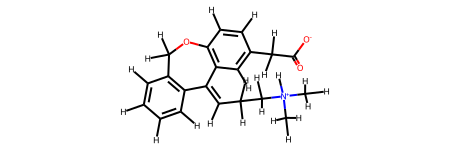

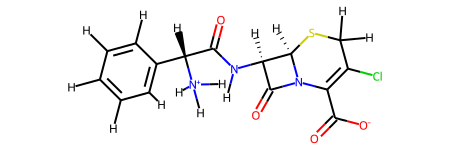

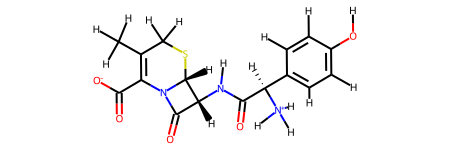

Large RMSD, > 1 Angstrom  56 mols


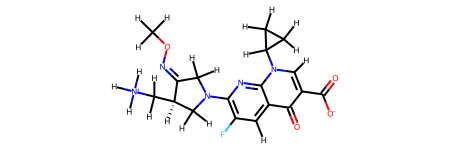

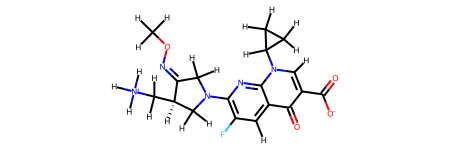

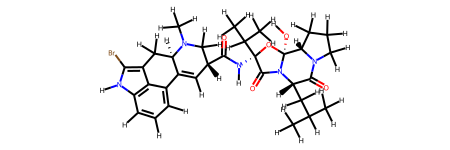

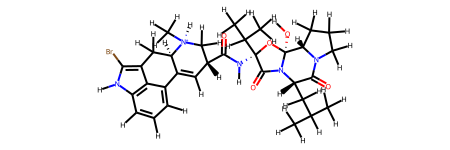

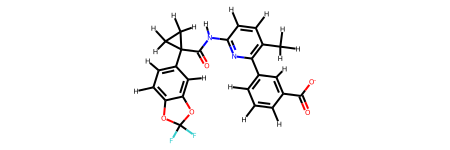

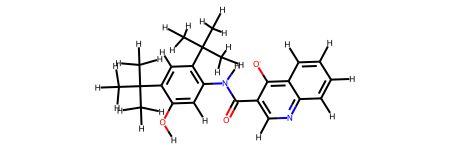

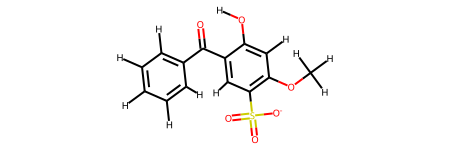

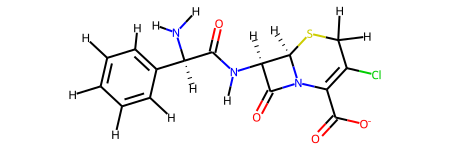

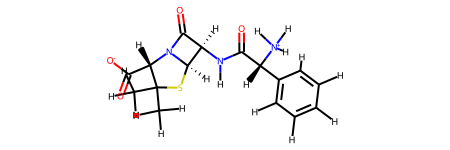

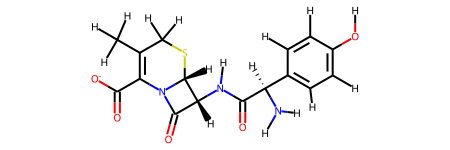

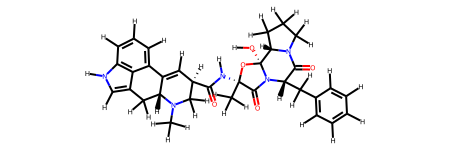

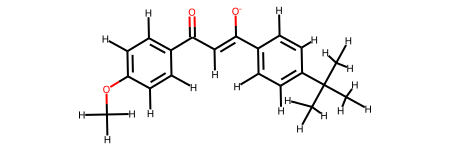

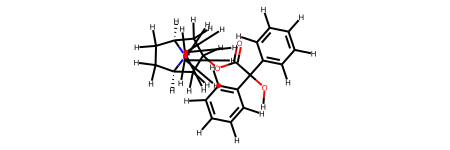

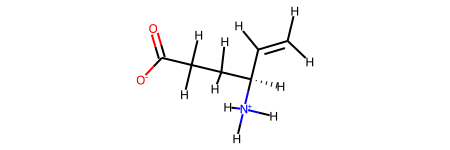

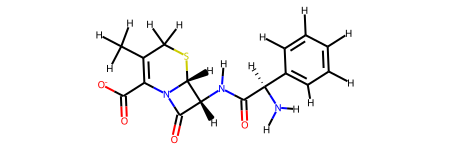

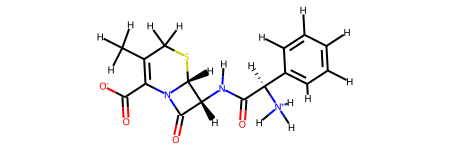

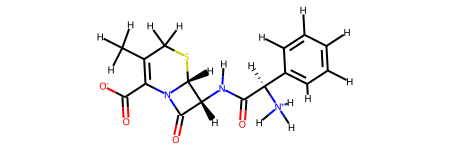

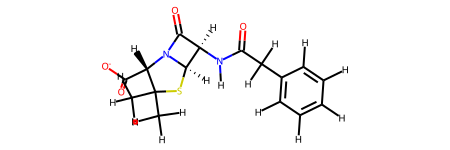

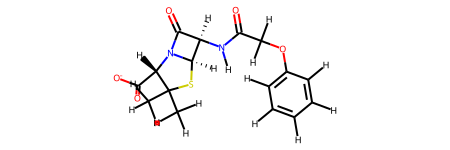

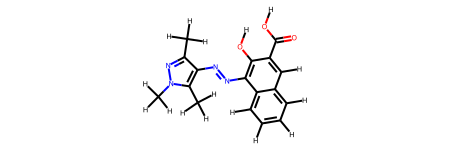

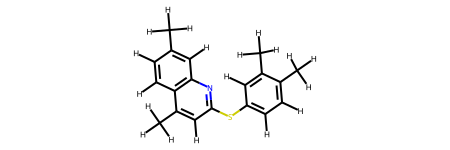

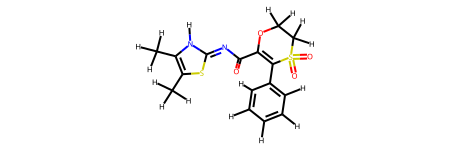

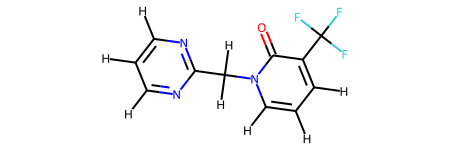

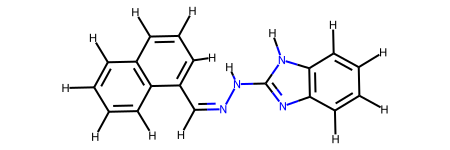

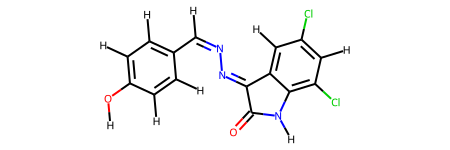

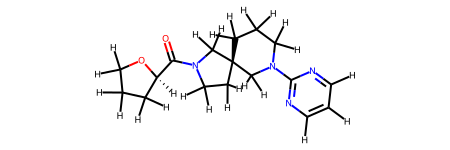

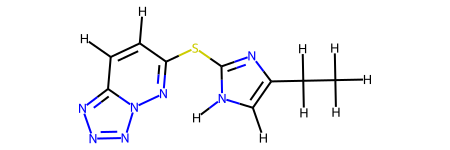

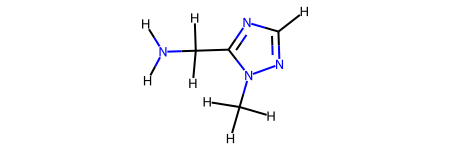

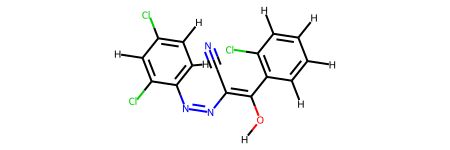

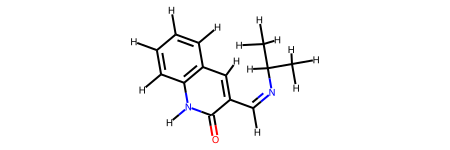

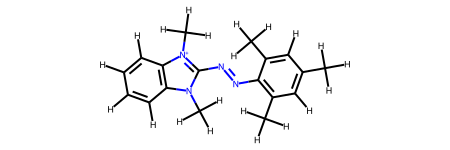

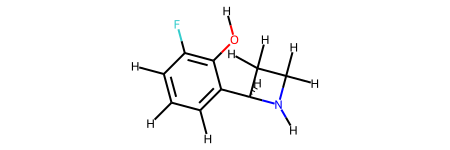

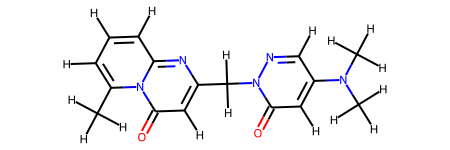

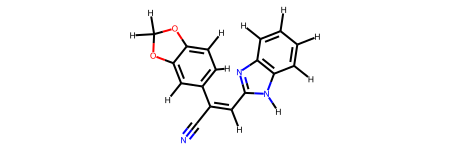

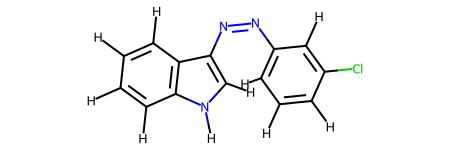

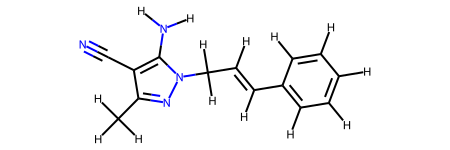

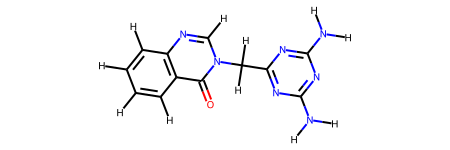

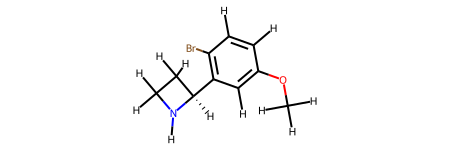

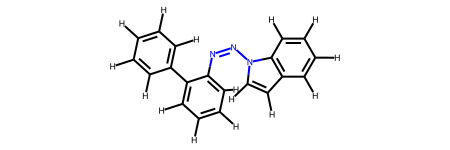

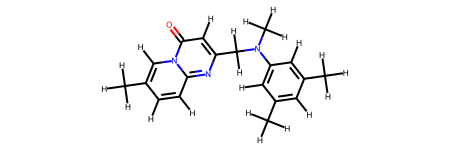

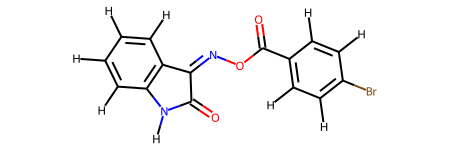

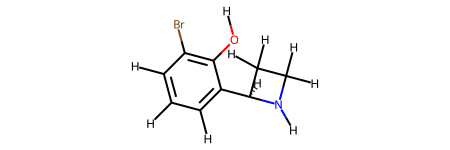

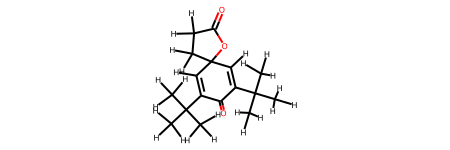

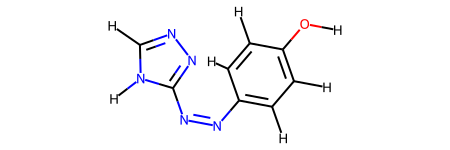

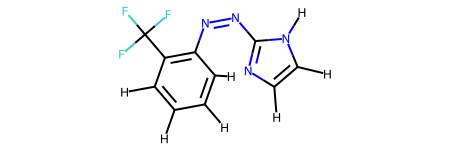

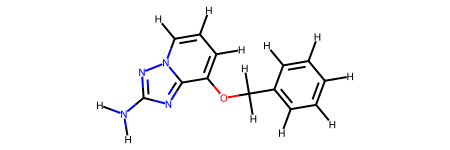

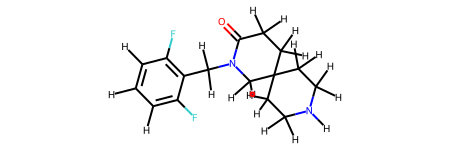

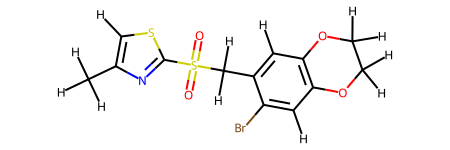

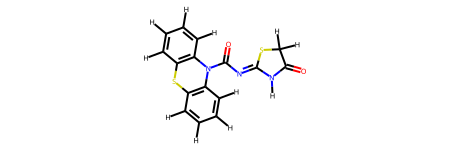

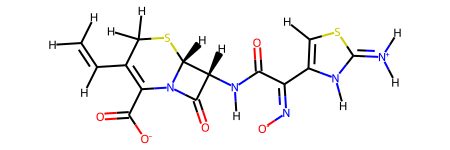

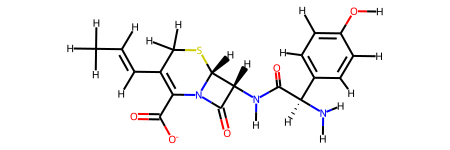

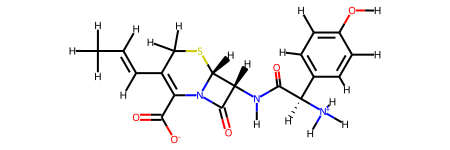

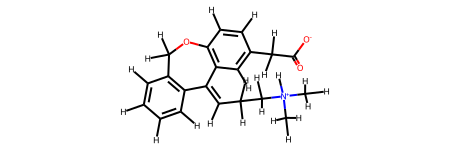

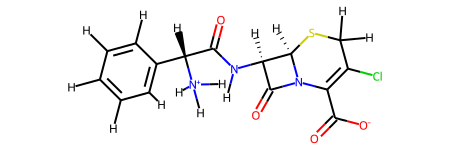

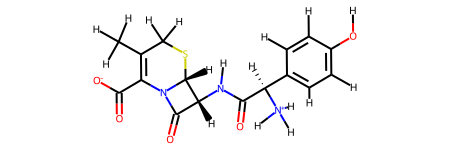

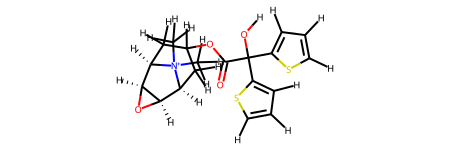

Large TFD, > 0.1  410 mols


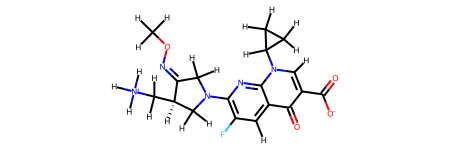

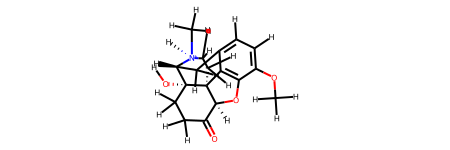

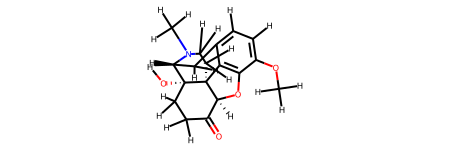

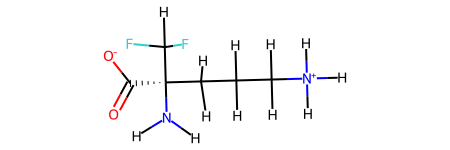

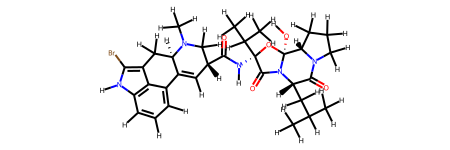

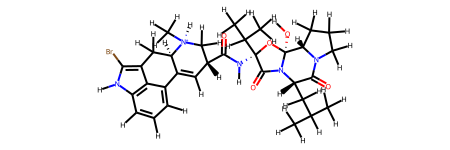

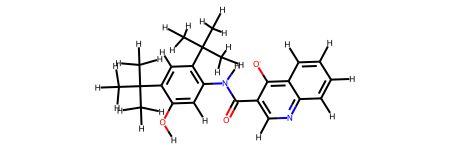

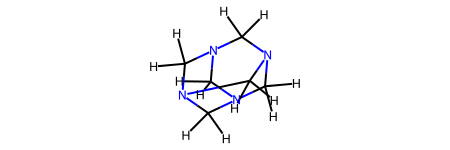

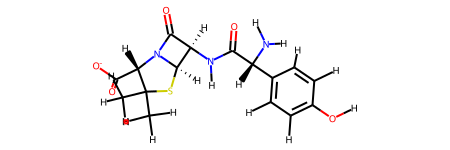

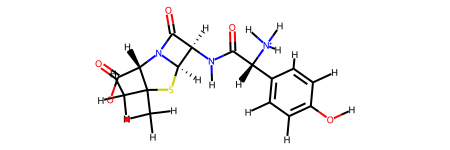

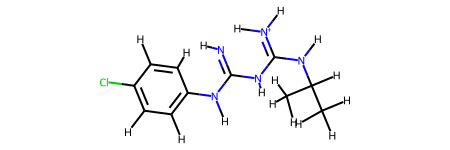

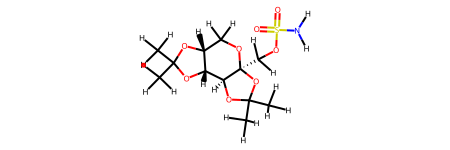

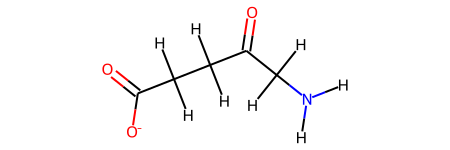

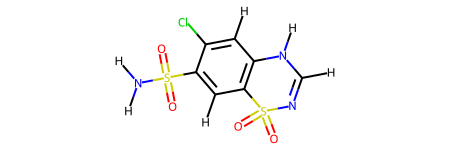

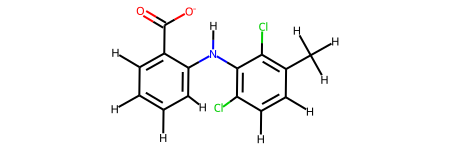

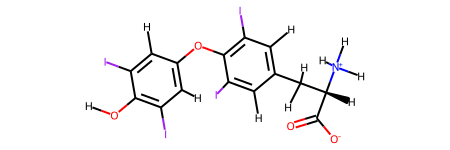

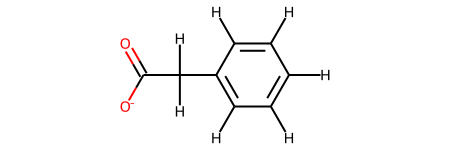

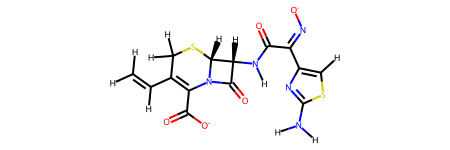

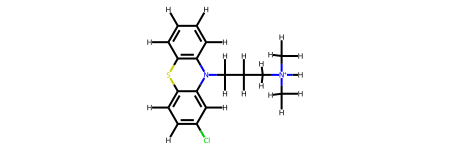

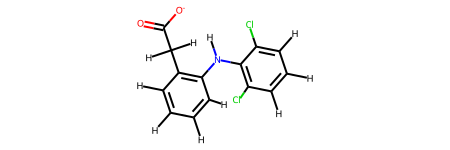

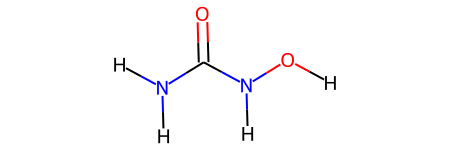

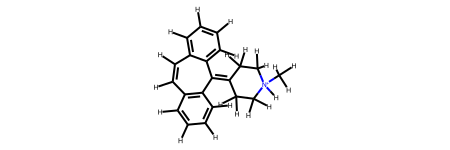

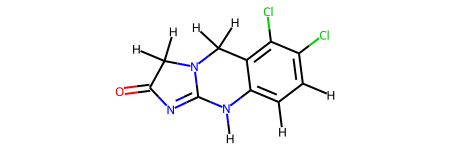

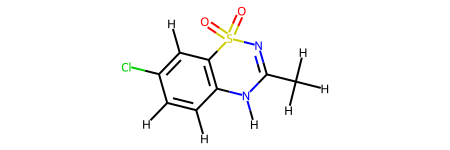

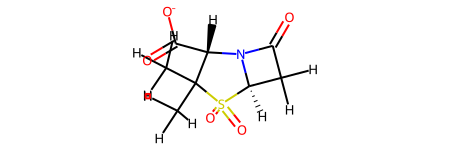

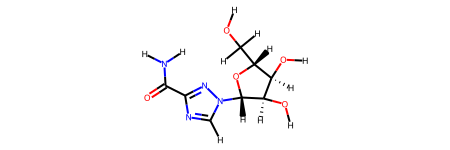

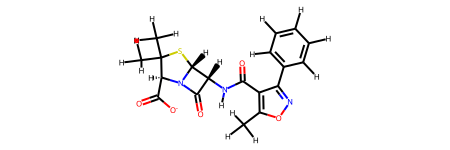

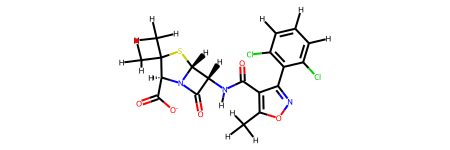

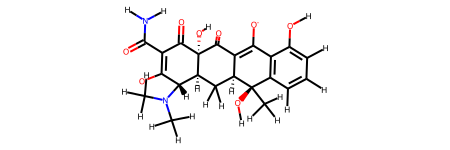

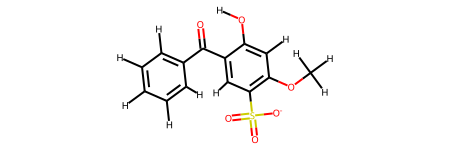

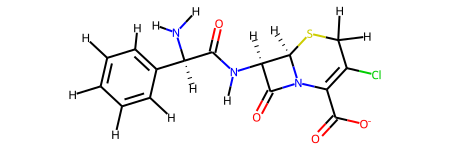

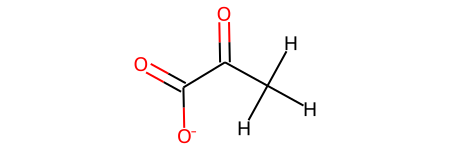

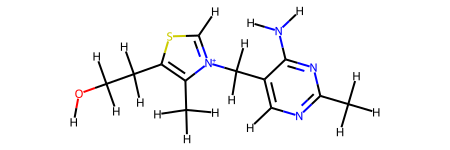

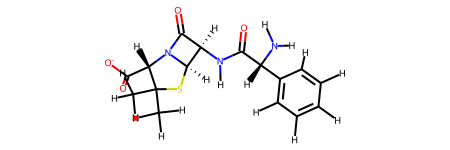

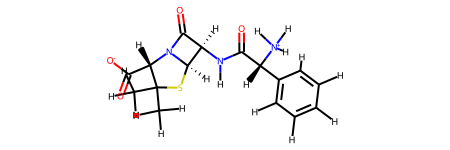

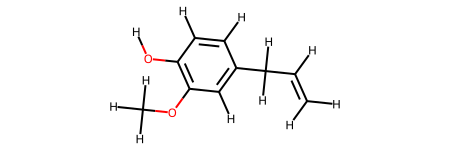

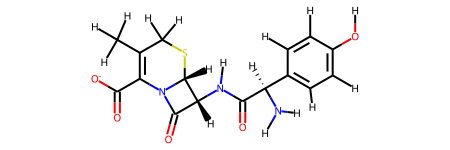

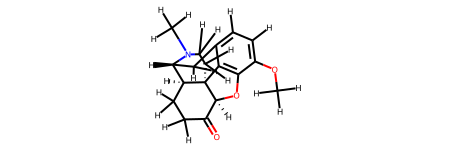

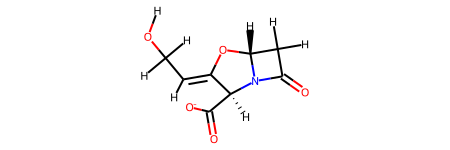

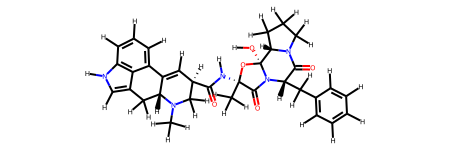

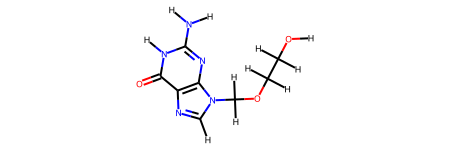

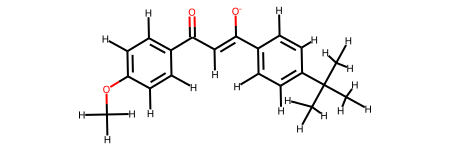

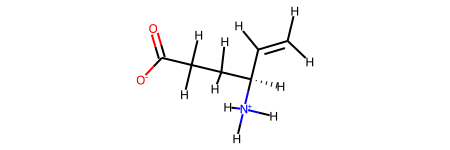

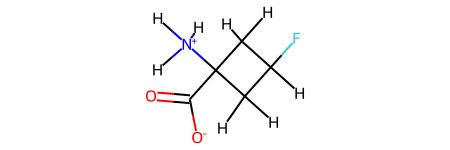

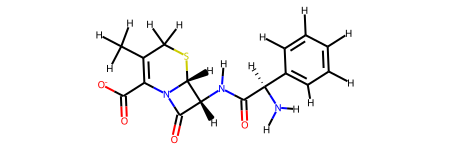

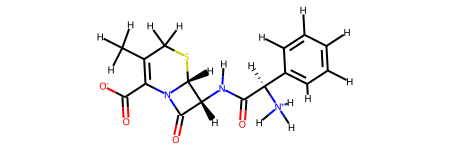

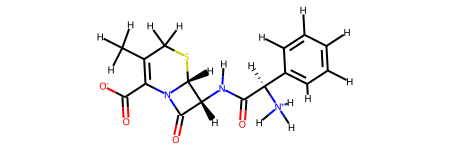

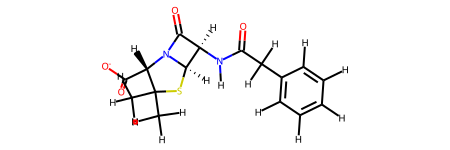

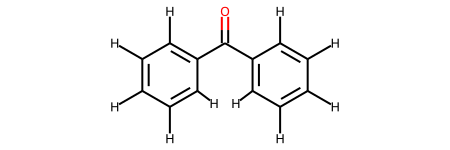

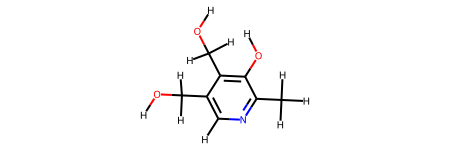

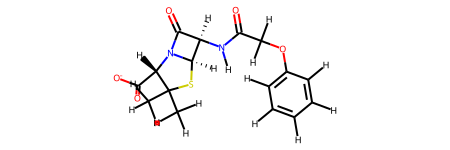

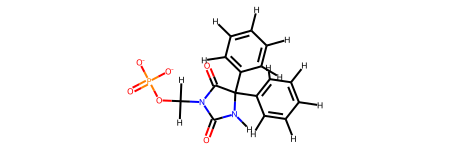

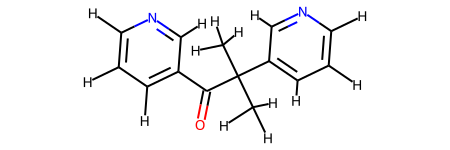

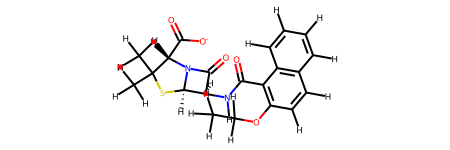

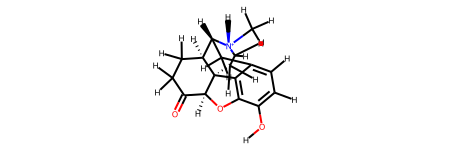

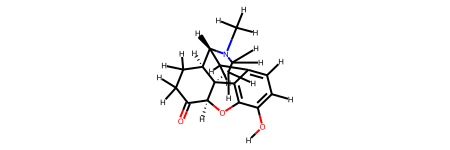

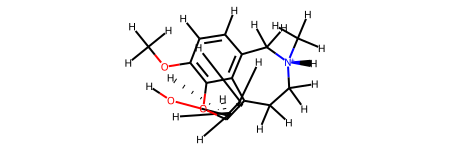

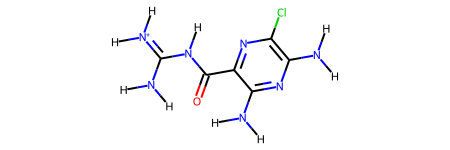

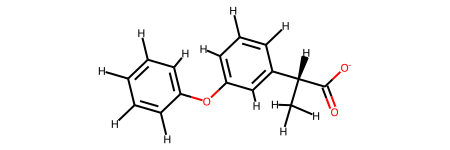

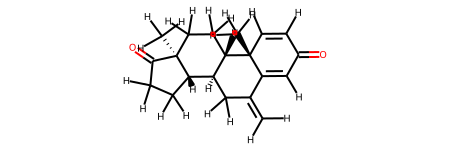

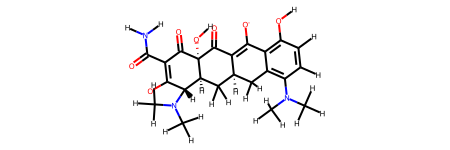

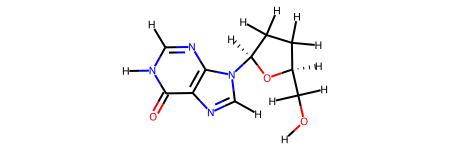

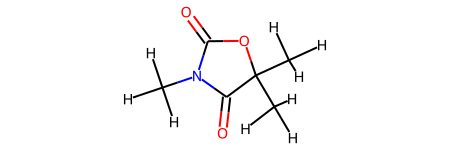

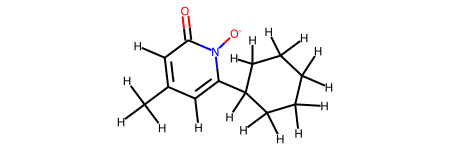

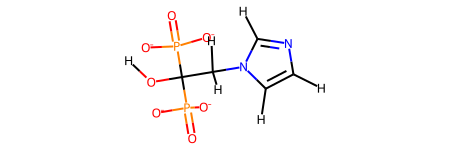

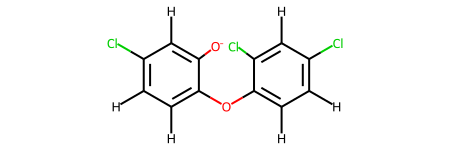

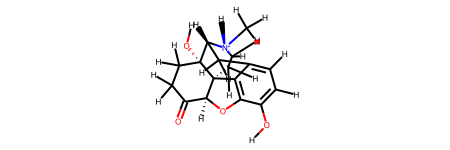

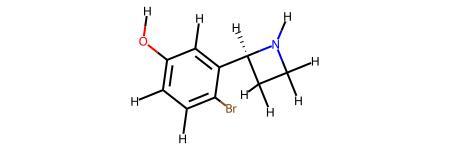

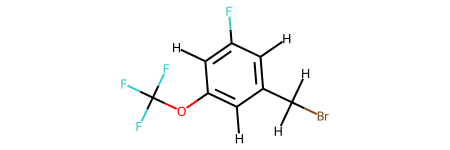

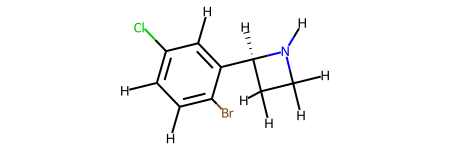

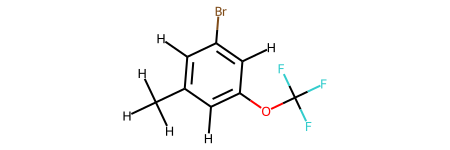

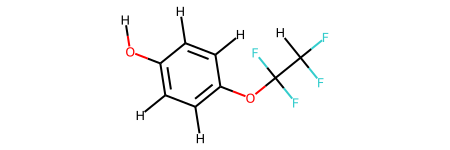

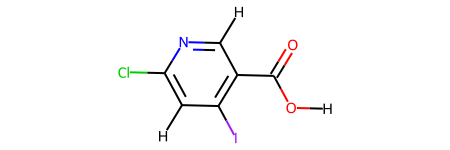

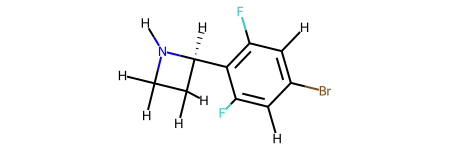

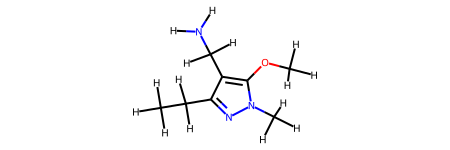

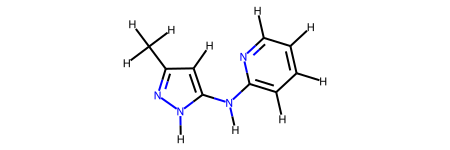

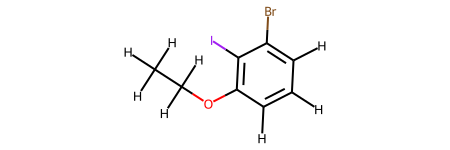

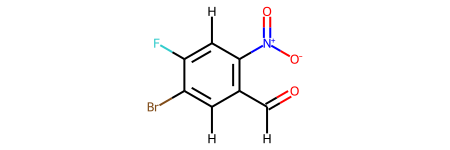

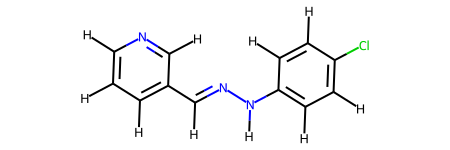

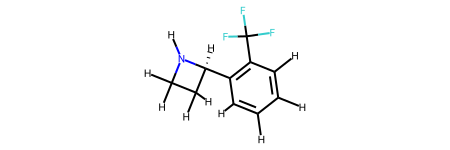

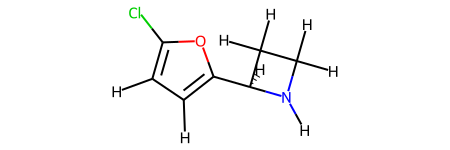

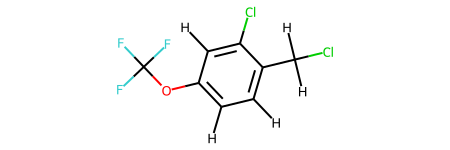

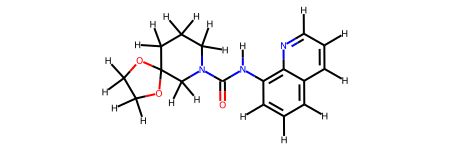

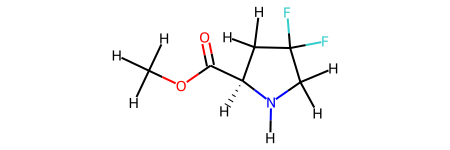

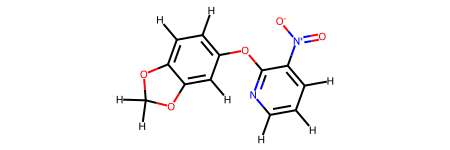

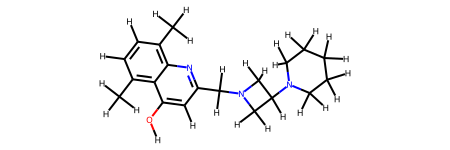

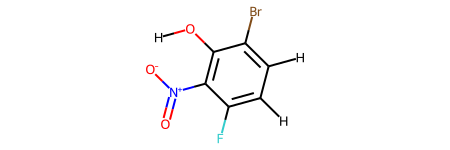

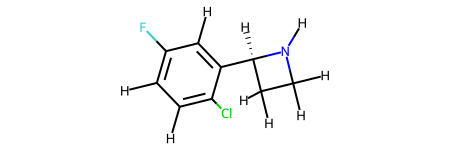

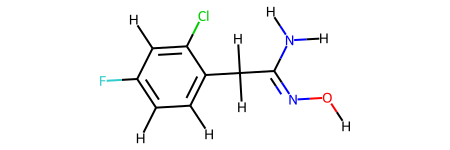

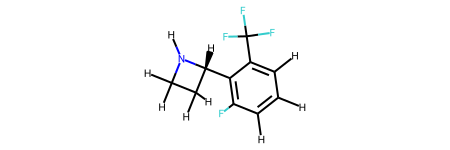

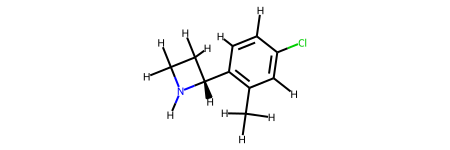

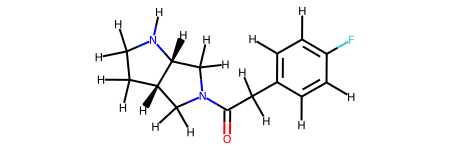

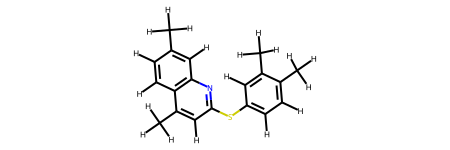

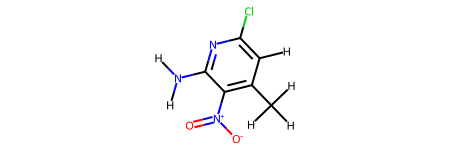

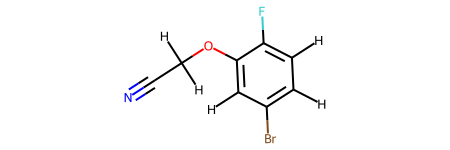

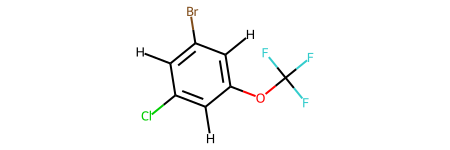

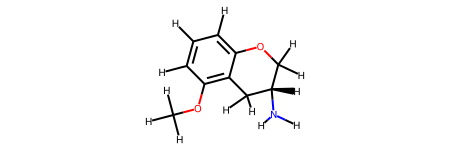

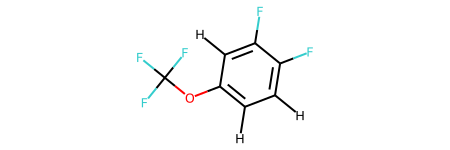

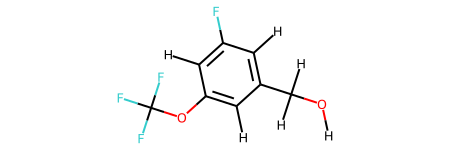

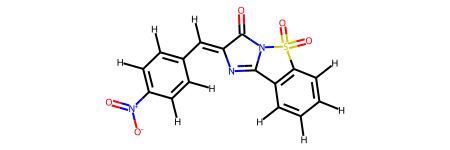

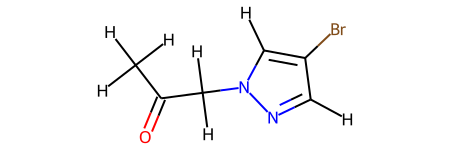

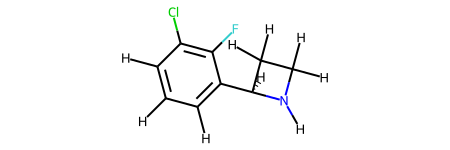

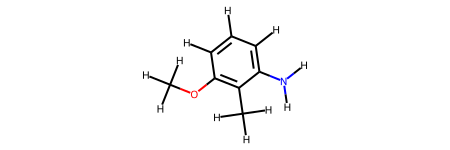

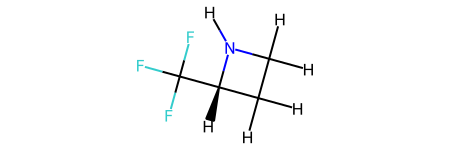

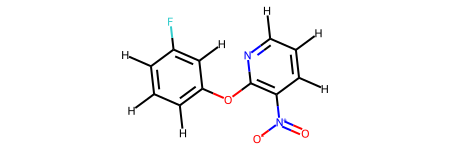

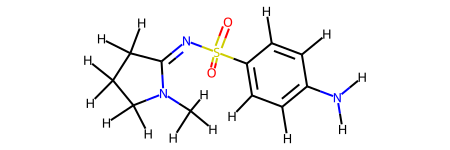

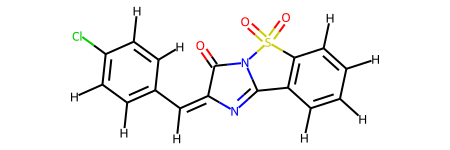

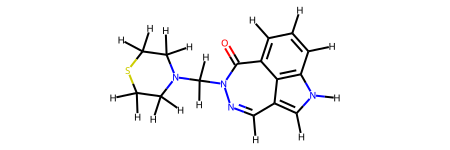

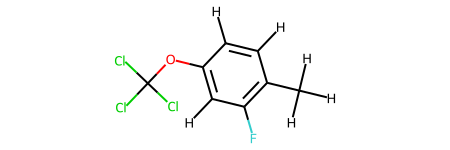

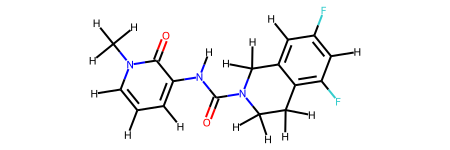

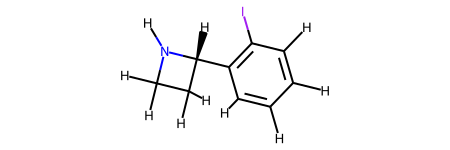

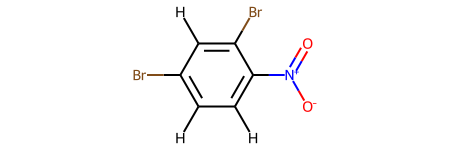

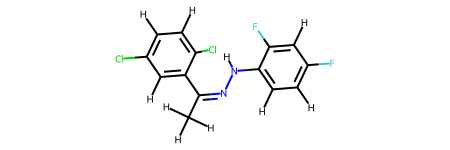

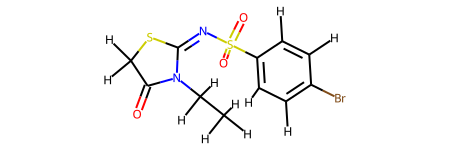

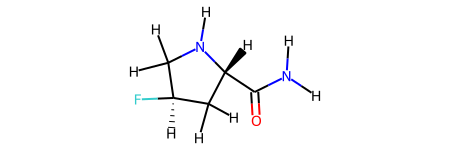

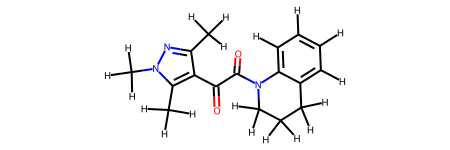

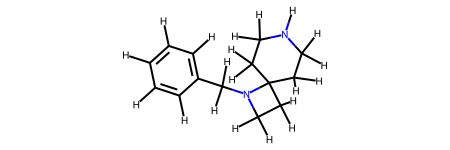

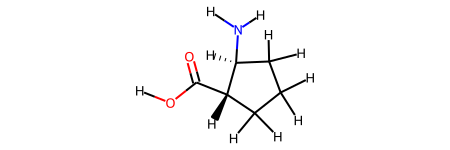

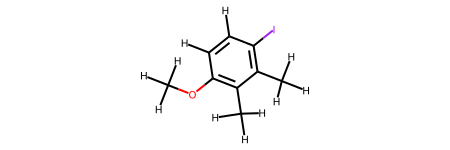

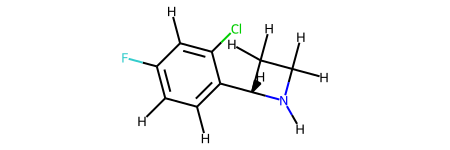

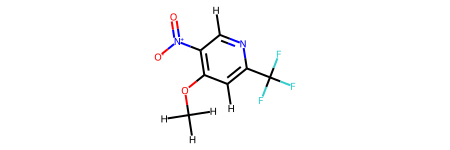

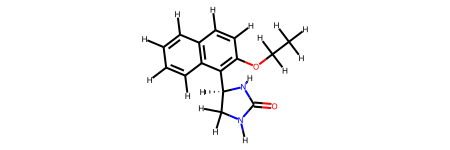

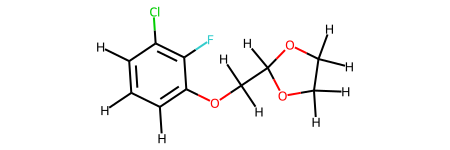

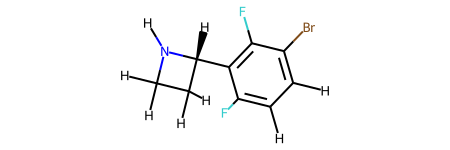

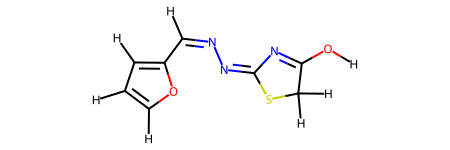

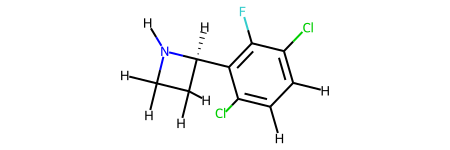

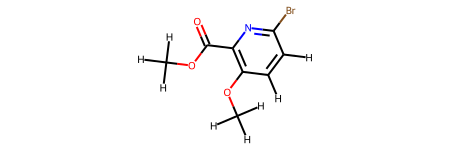

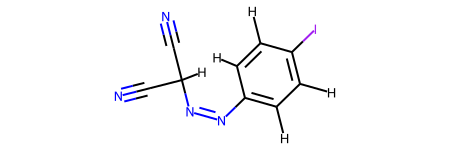

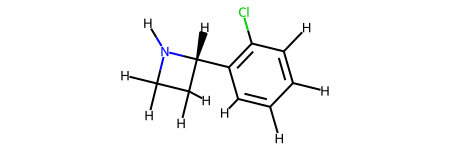

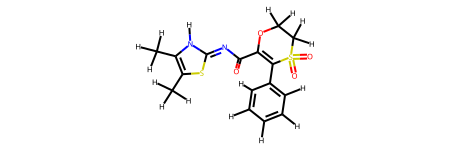

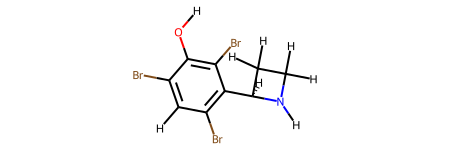

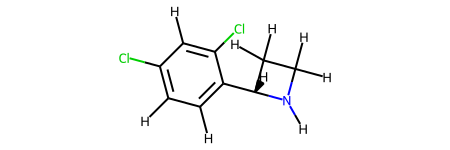

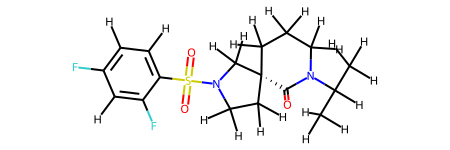

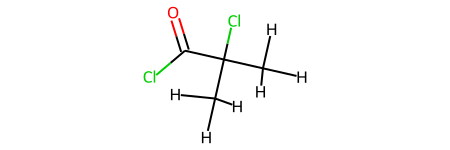

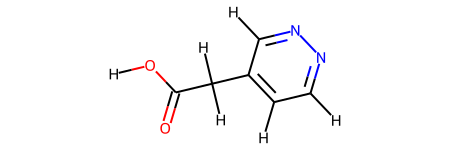

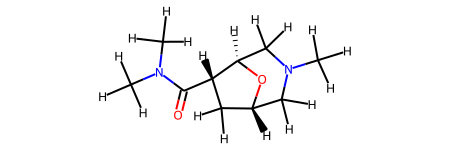

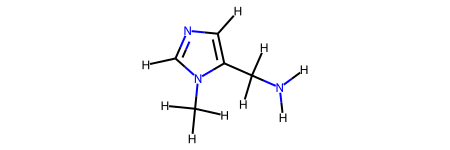

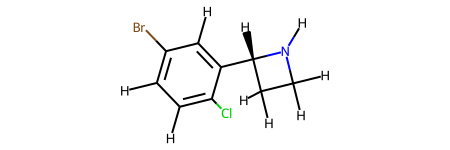

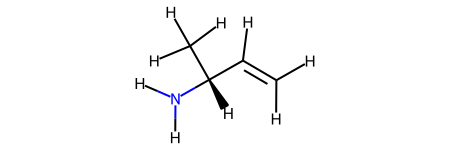

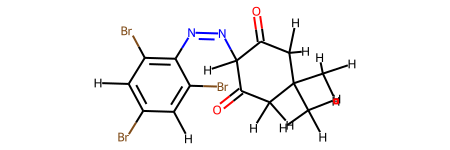

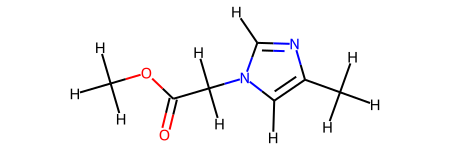

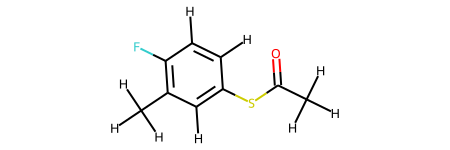

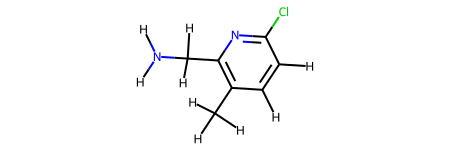

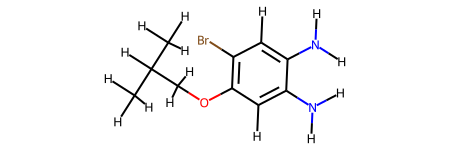

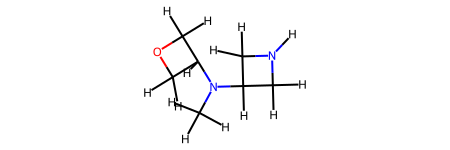

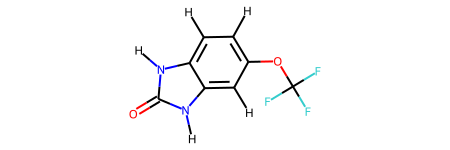

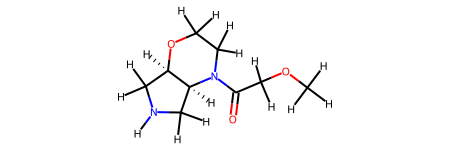

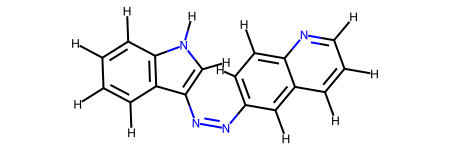

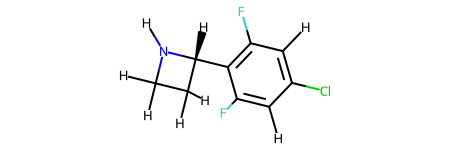

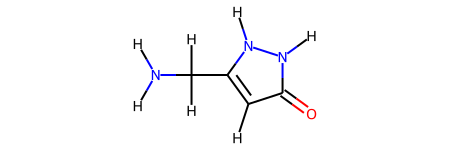

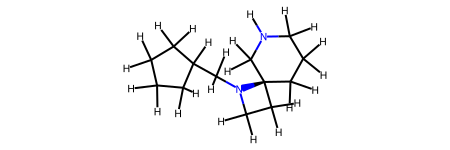

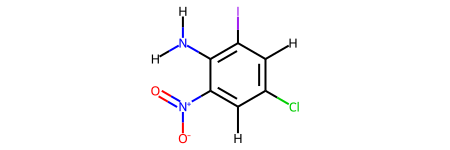

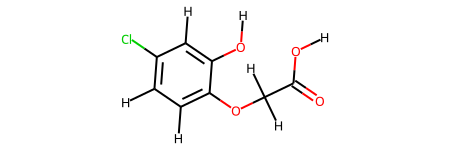

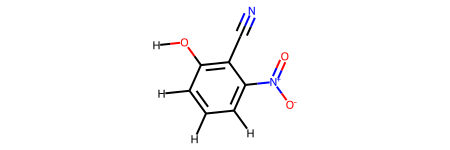

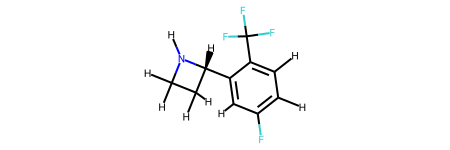

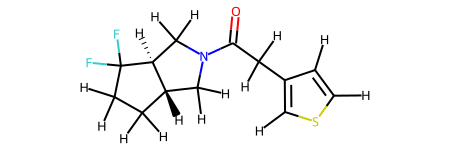

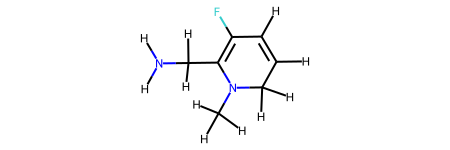

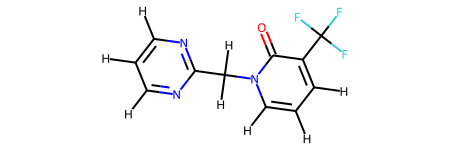

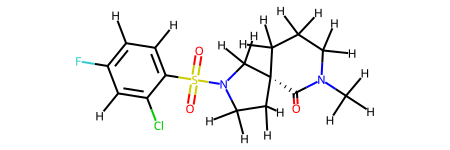

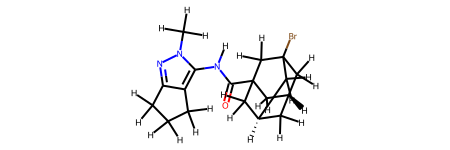

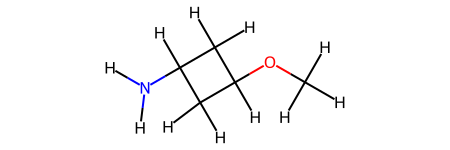

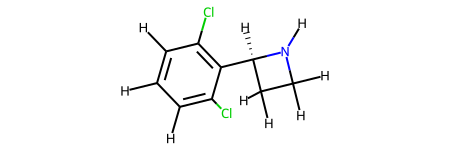

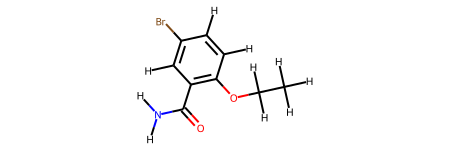

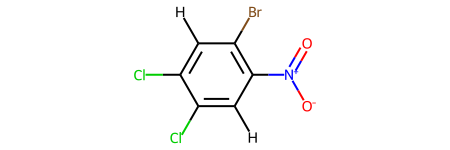

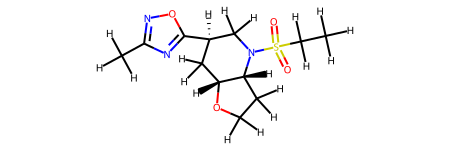

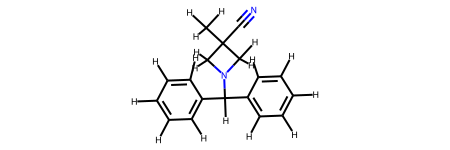

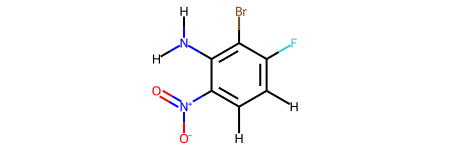

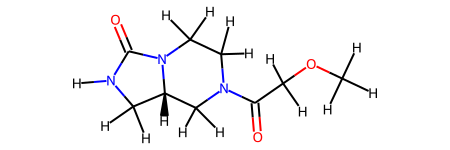

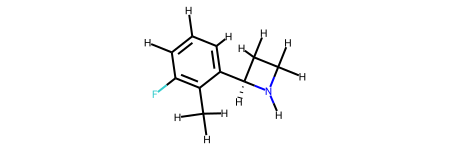

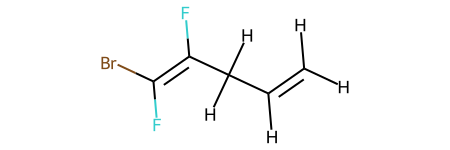

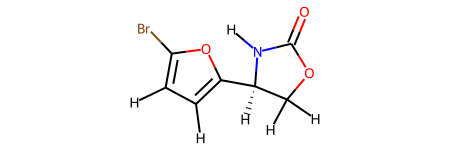

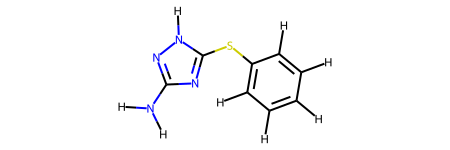

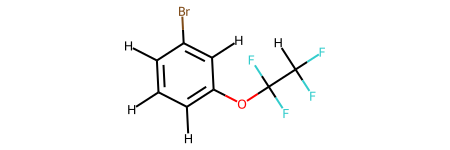

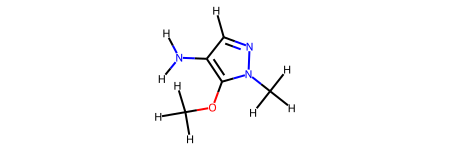

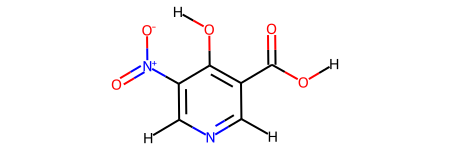

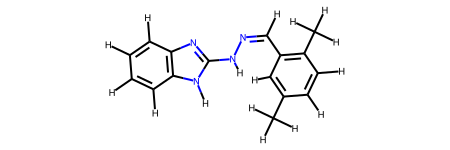

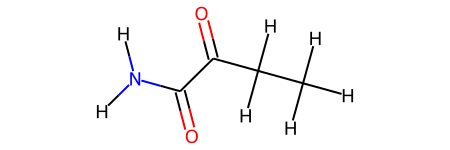

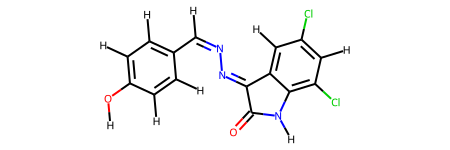

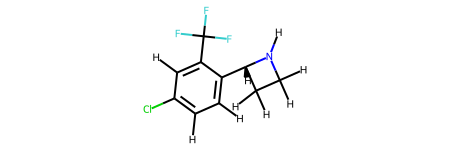

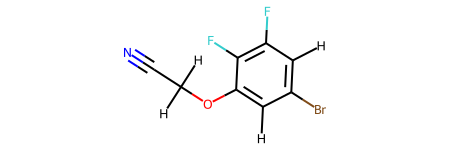

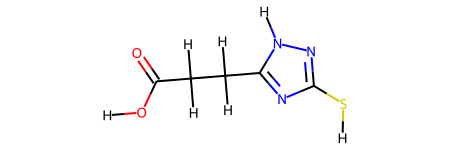

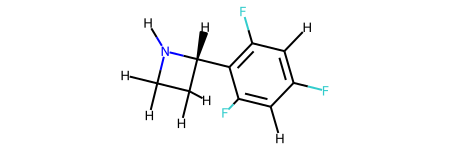

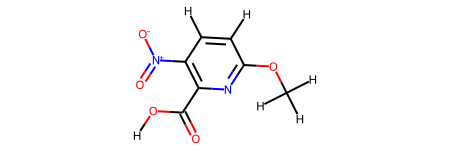

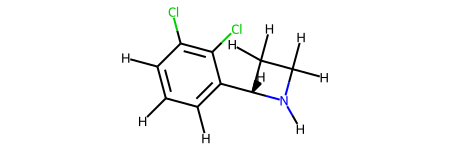

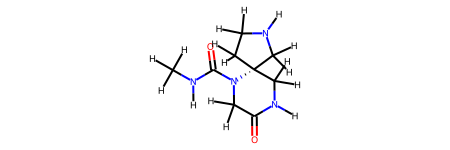

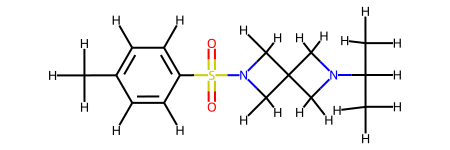

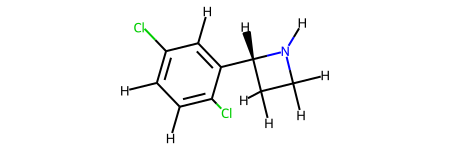

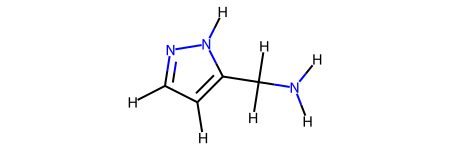

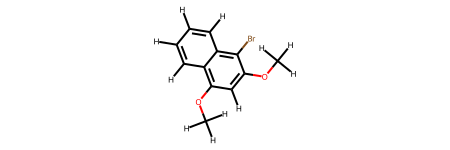

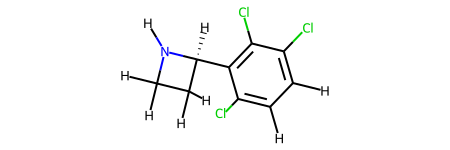

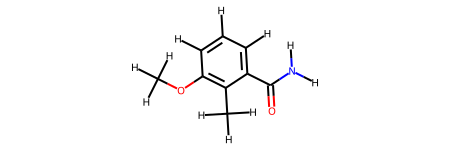

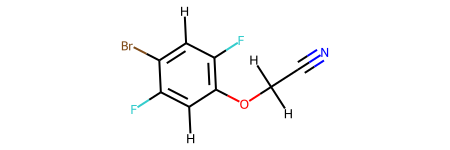

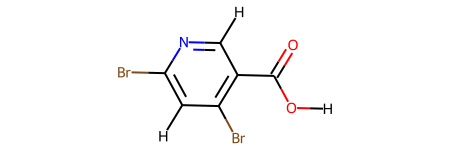

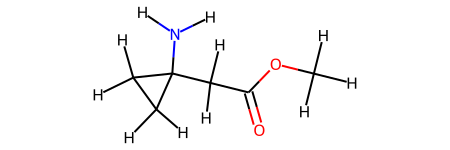

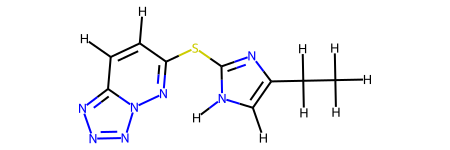

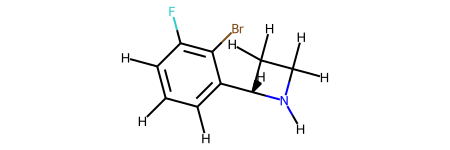

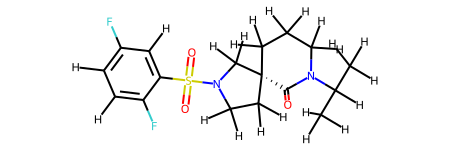

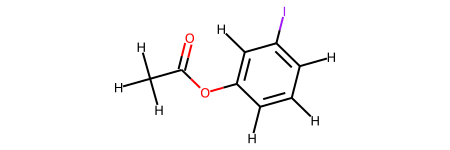

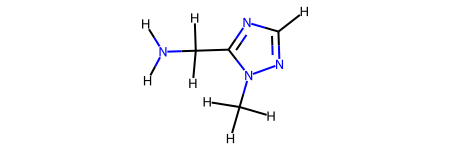

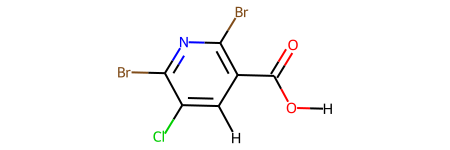

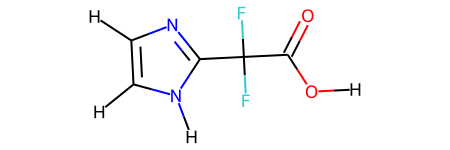

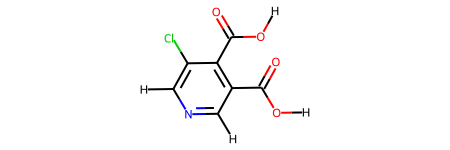

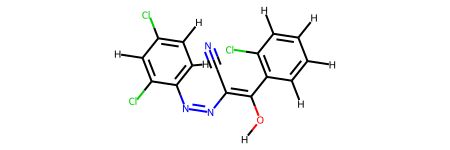

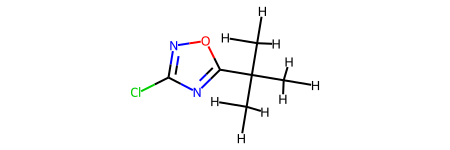

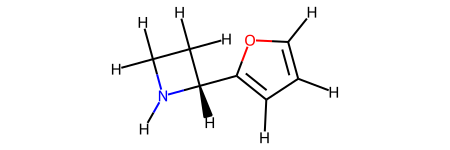

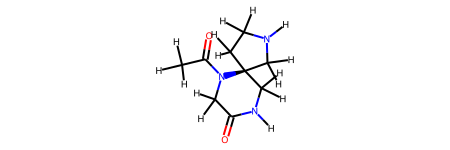

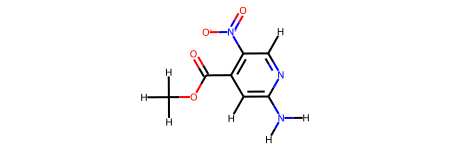

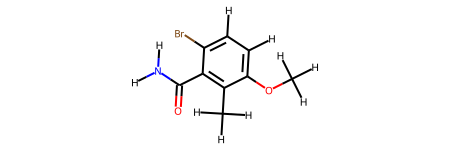

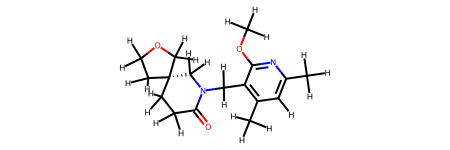

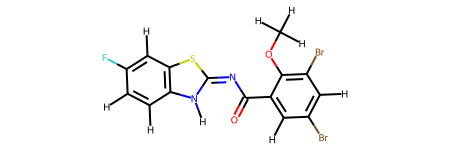

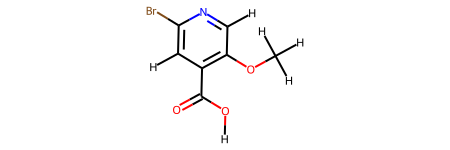

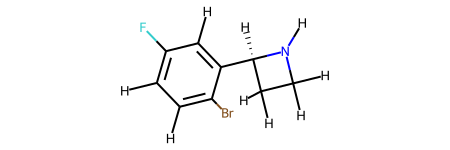

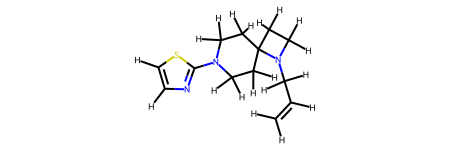

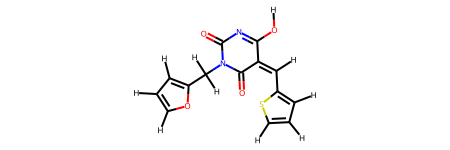

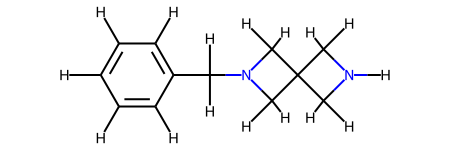

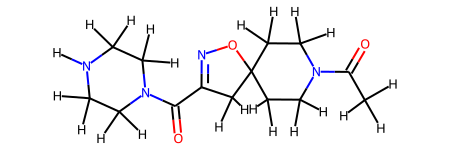

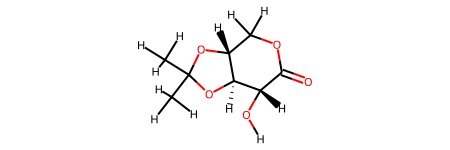

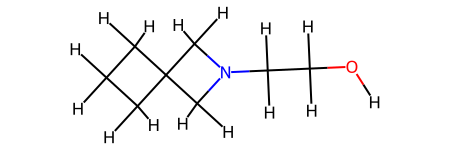

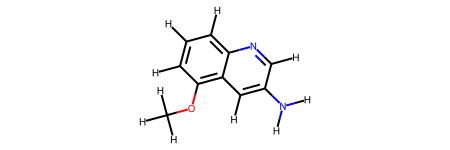

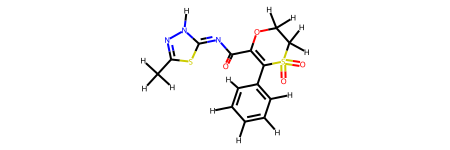

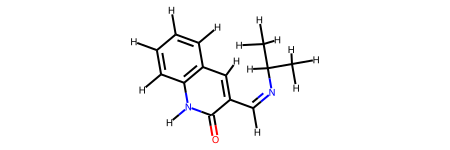

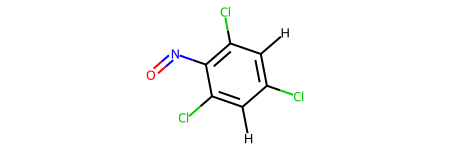

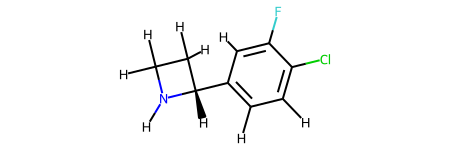

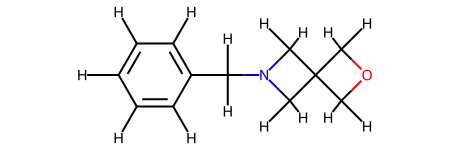

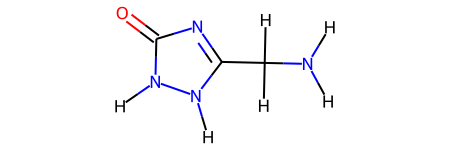

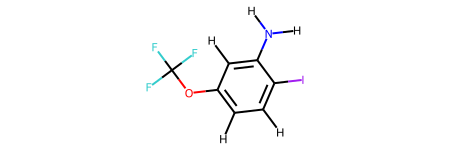

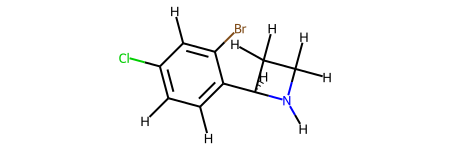

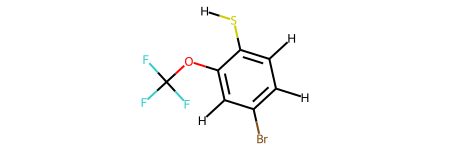

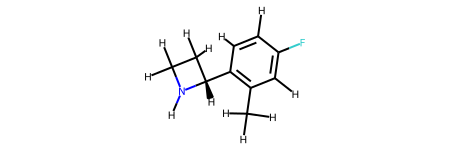

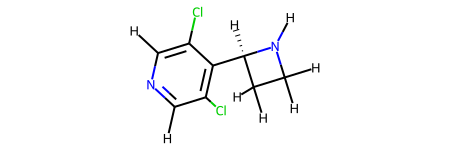

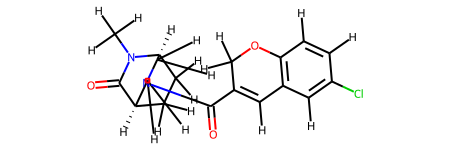

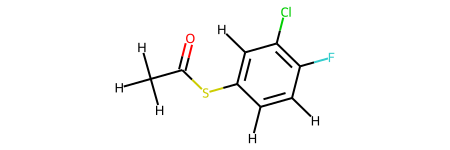

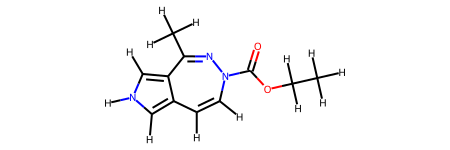

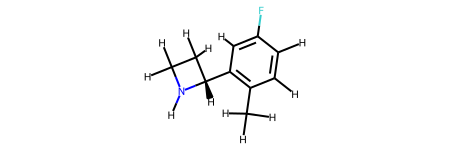

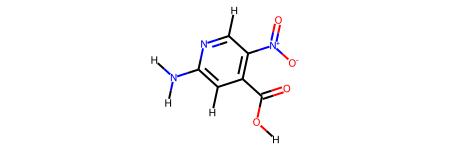

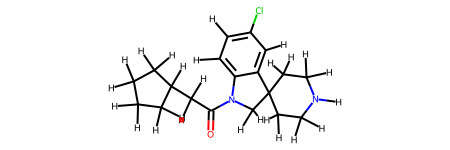

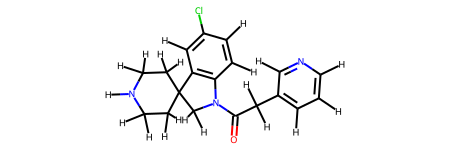

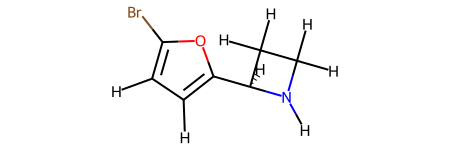

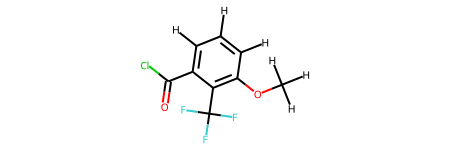

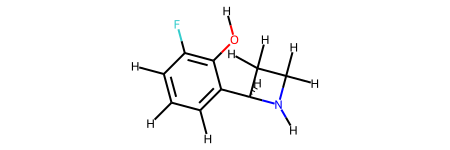

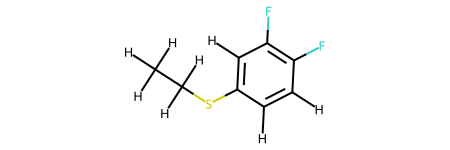

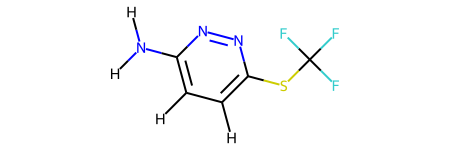

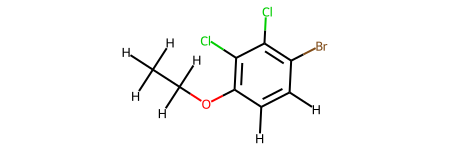

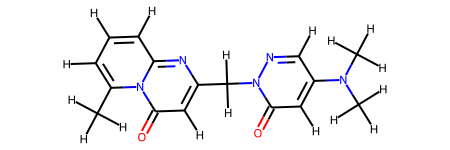

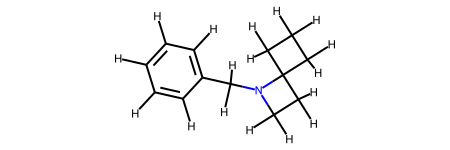

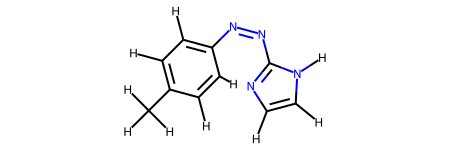

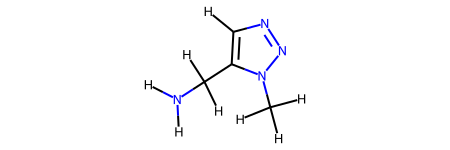

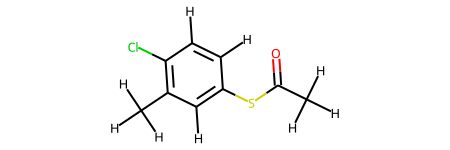

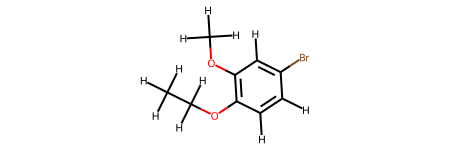

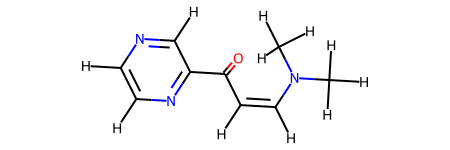

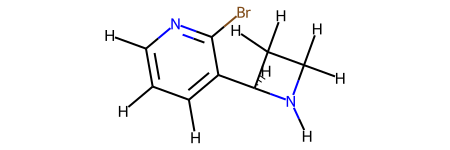

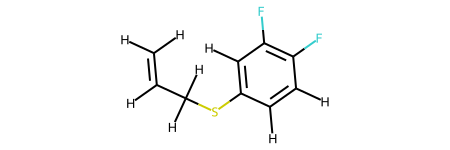

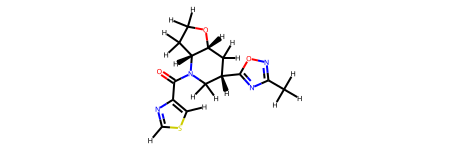

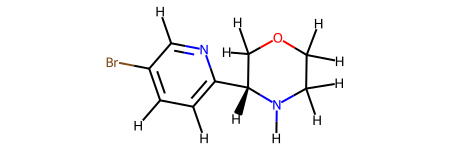

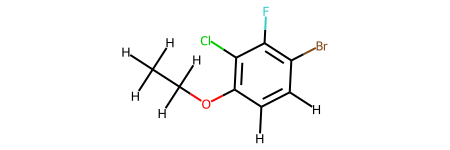

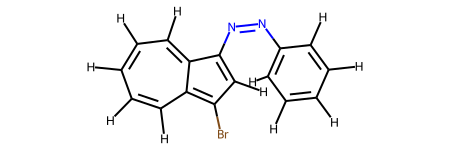

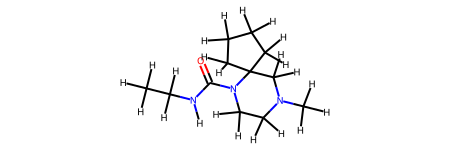

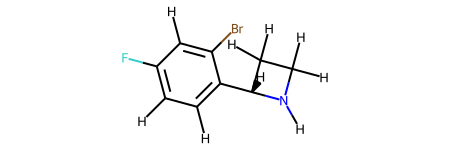

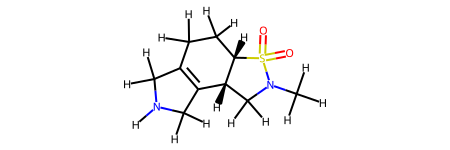

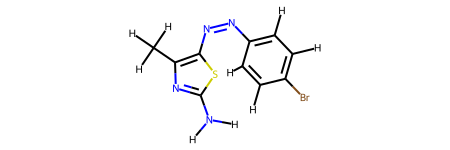

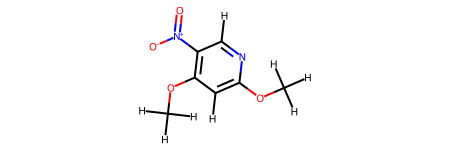

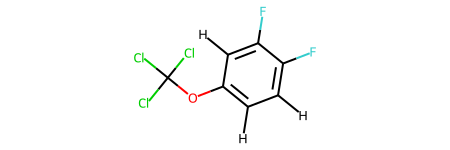

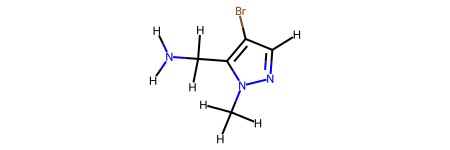

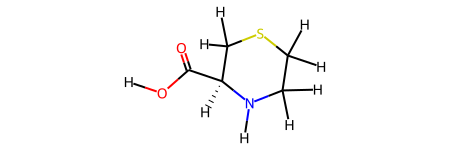

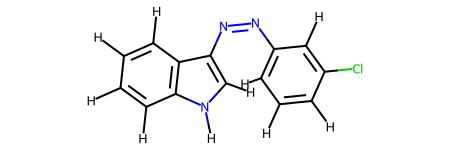

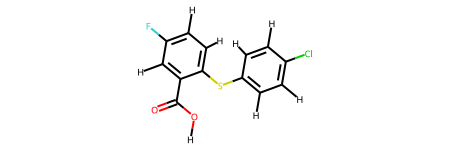

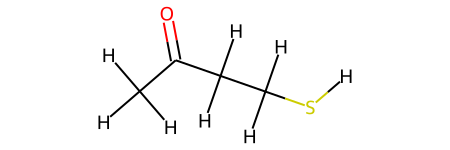

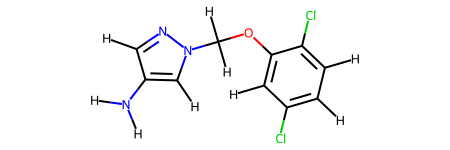

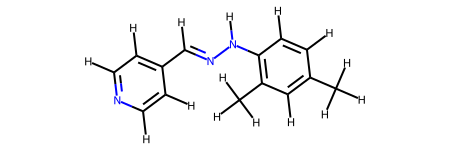

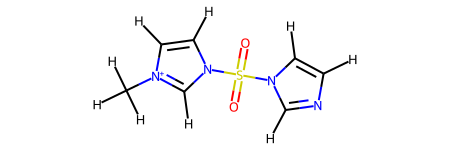

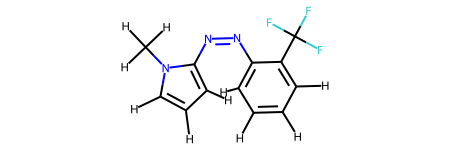

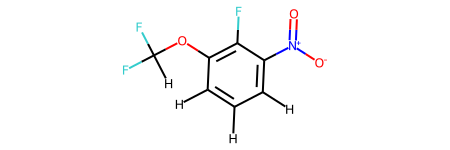

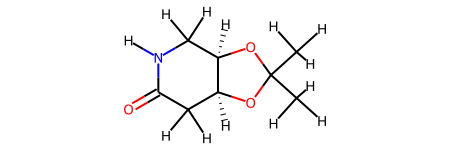

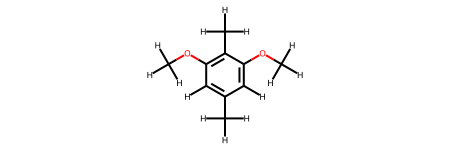

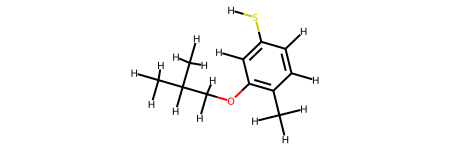

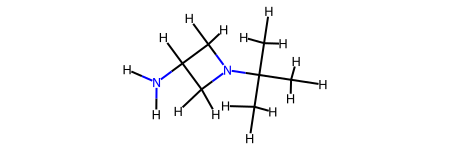

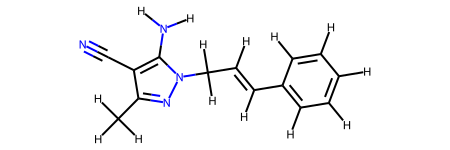

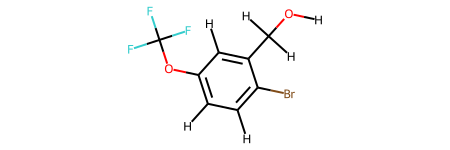

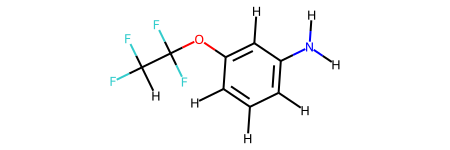

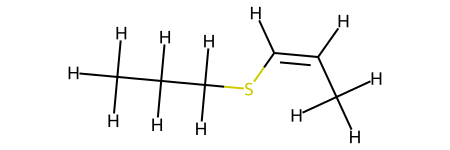

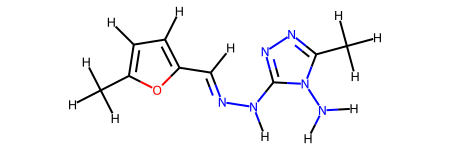

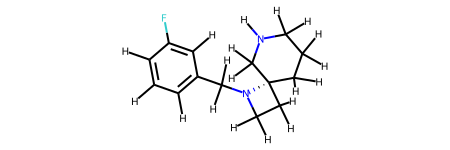

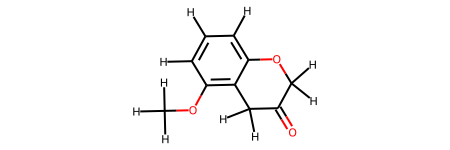

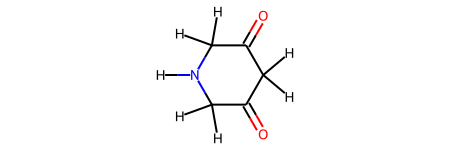

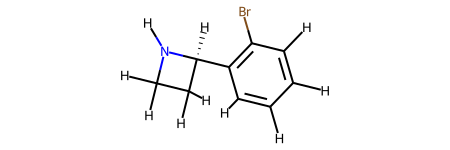

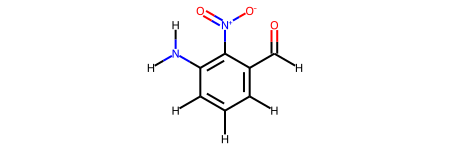

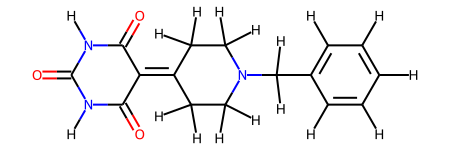

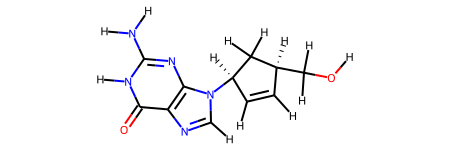

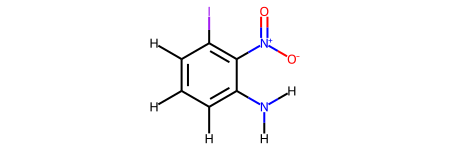

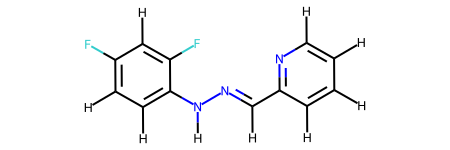

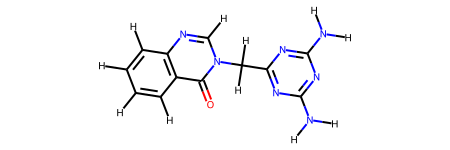

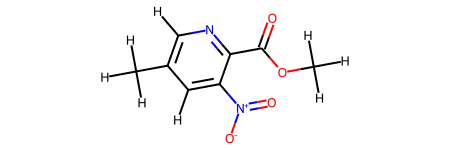

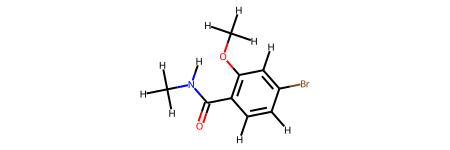

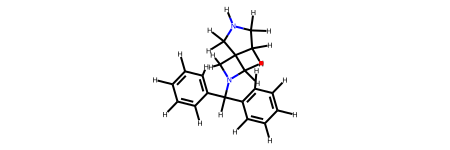

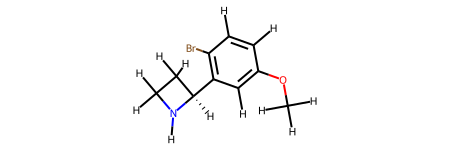

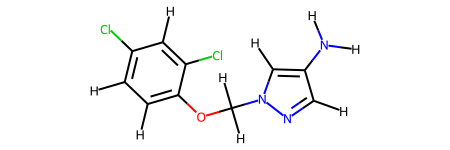

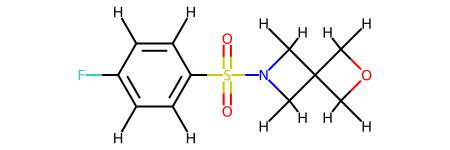

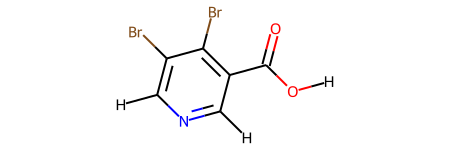

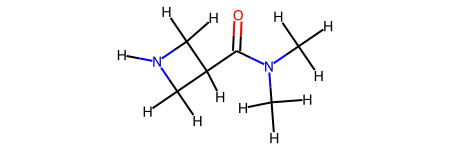

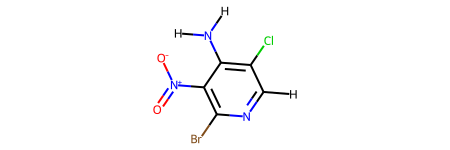

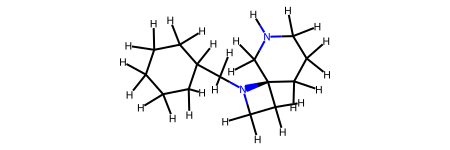

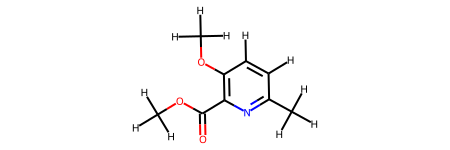

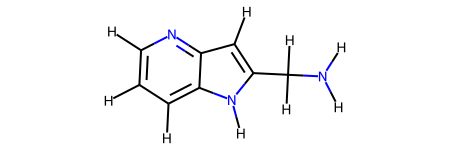

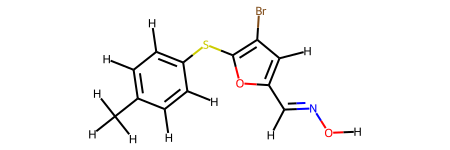

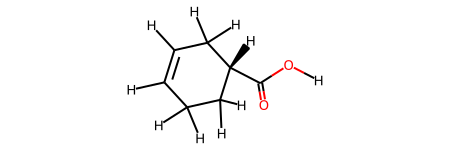

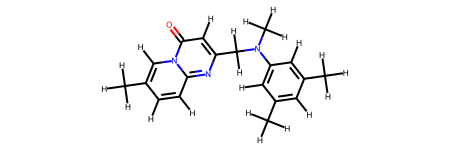

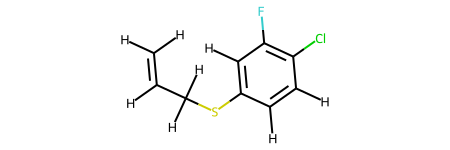

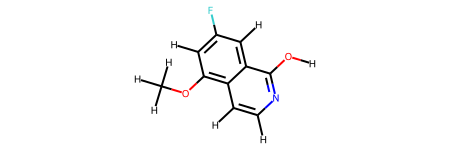

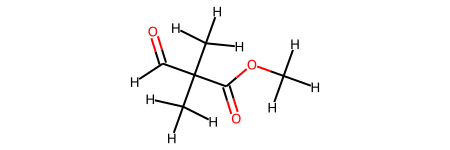

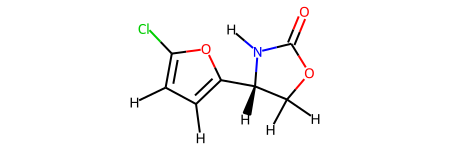

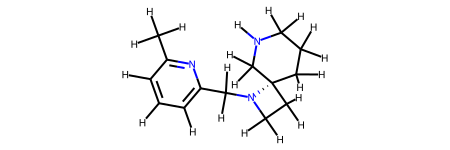

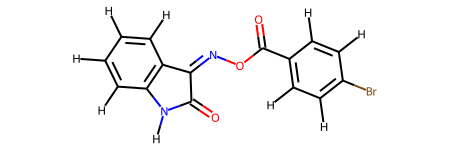

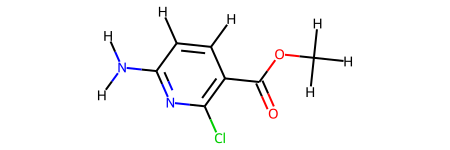

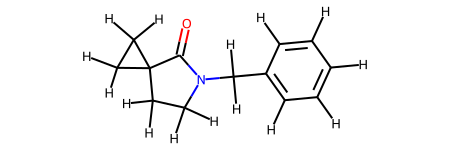

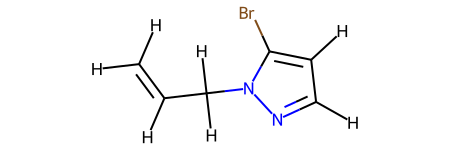

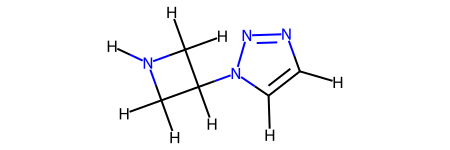

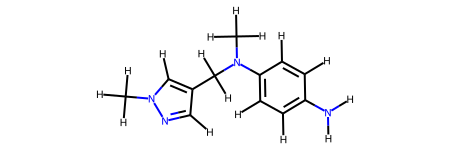

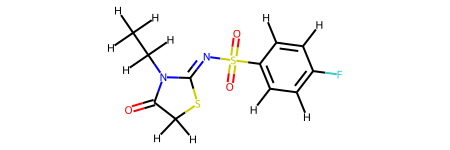

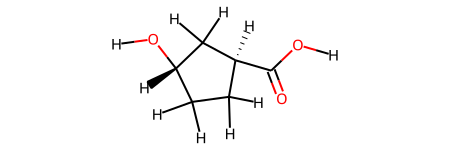

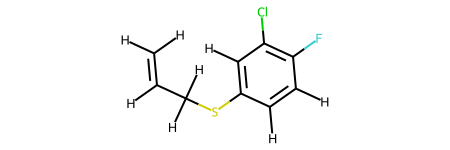

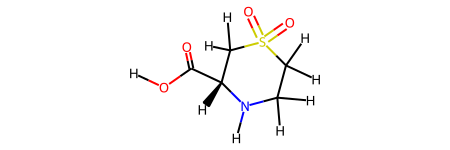

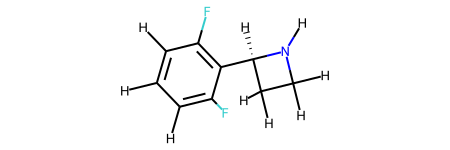

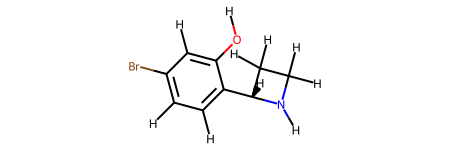

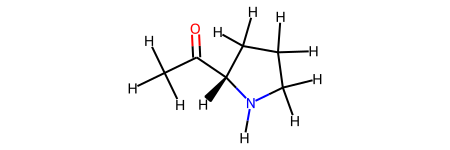

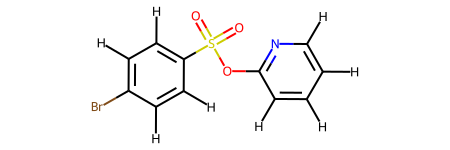

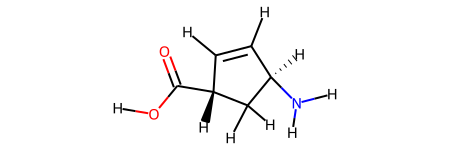

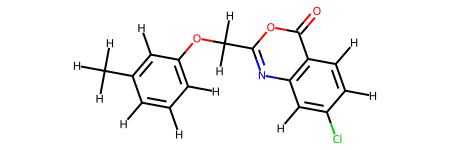

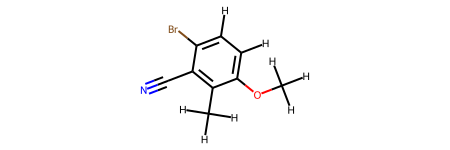

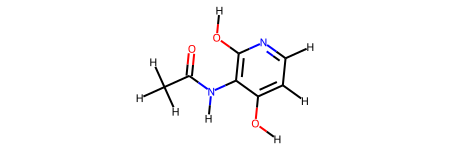

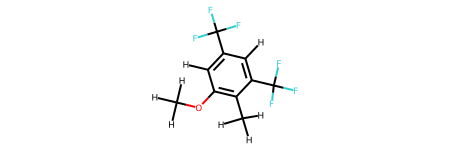

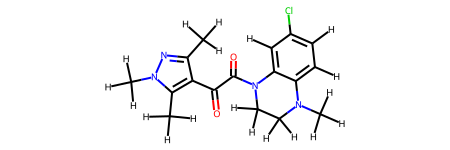

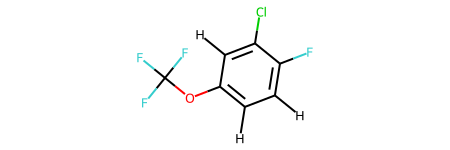

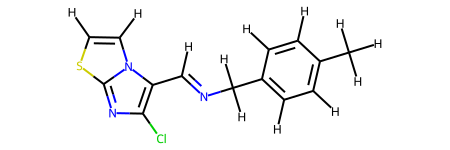

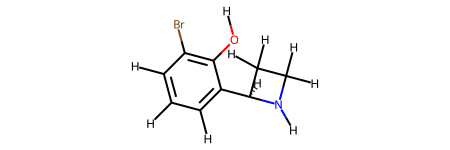

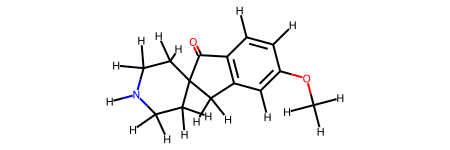

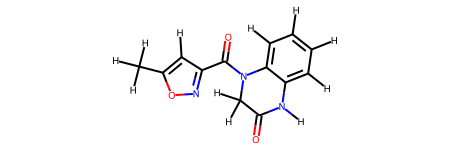

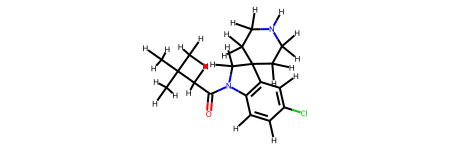

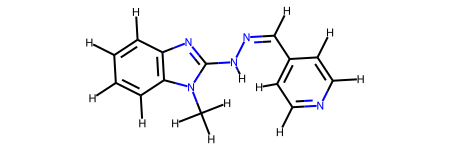

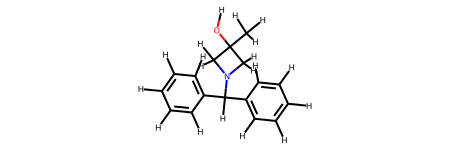

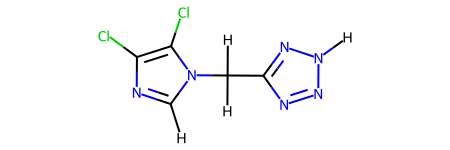

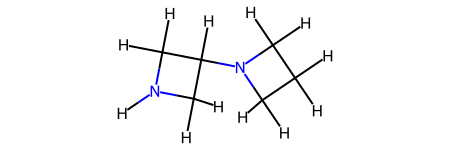

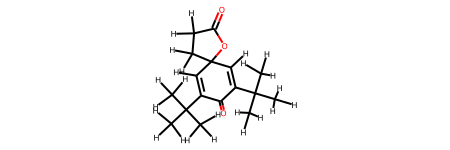

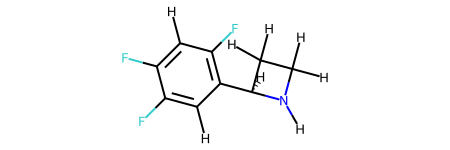

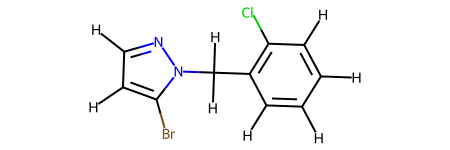

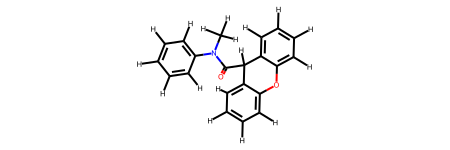

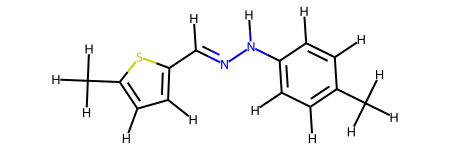

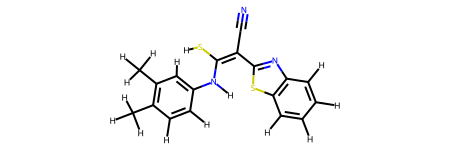

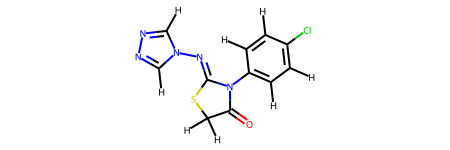

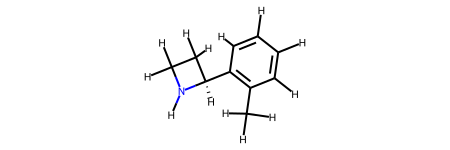

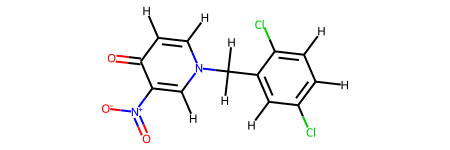

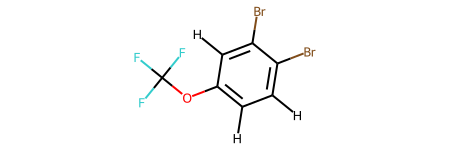

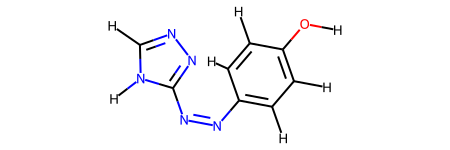

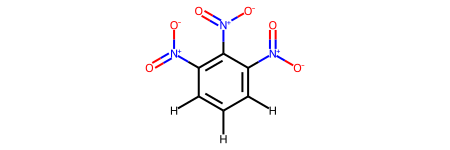

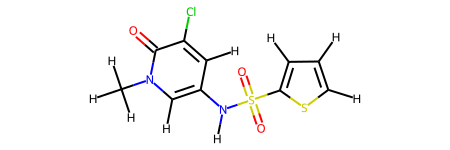

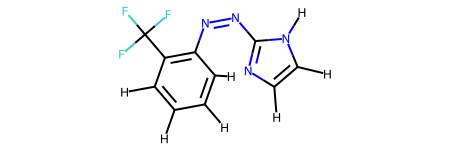

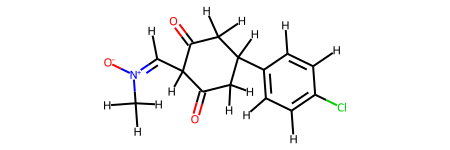

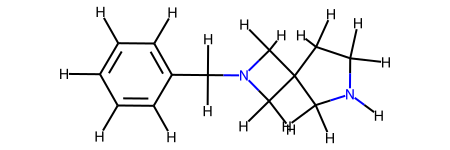

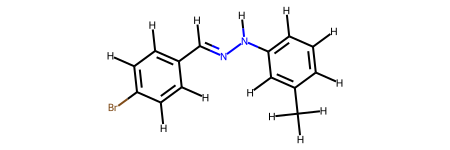

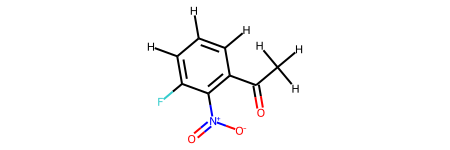

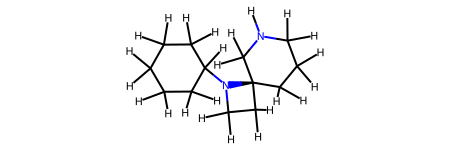

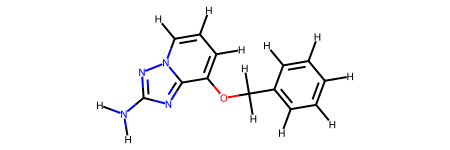

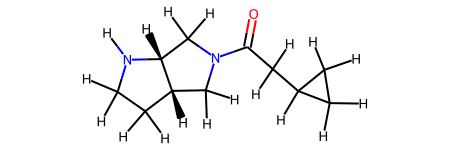

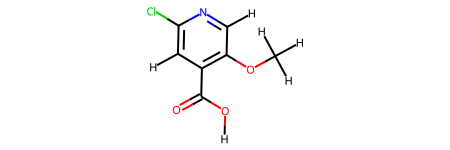

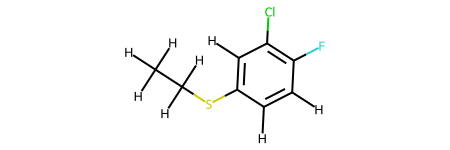

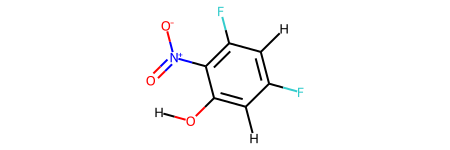

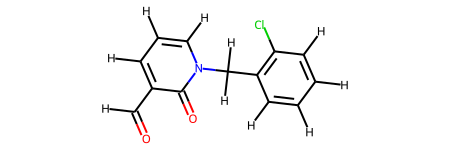

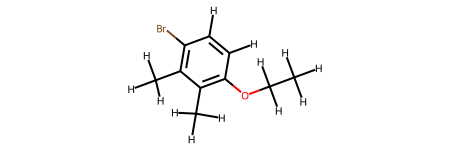

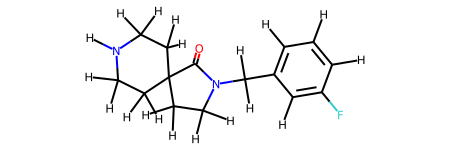

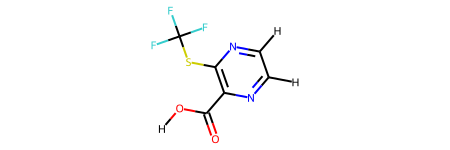

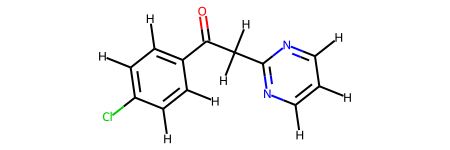

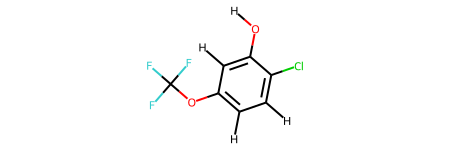

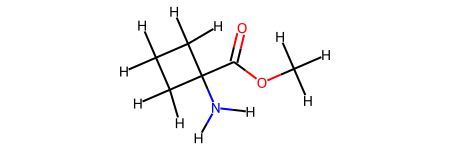

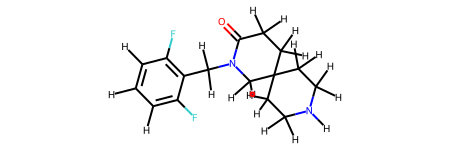

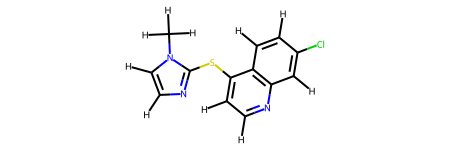

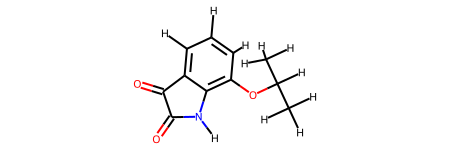

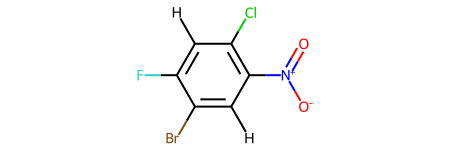

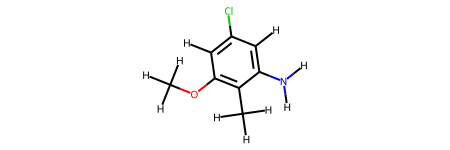

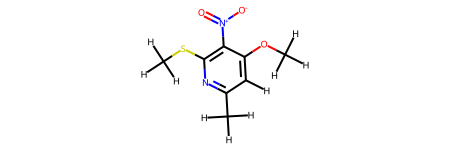

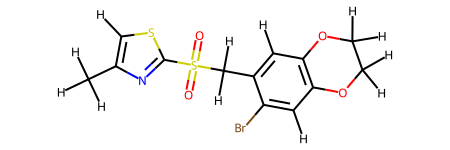

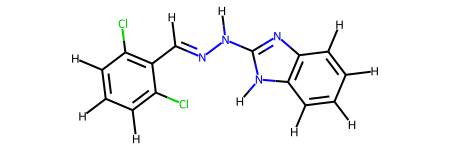

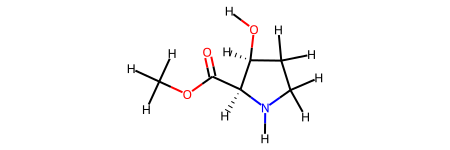

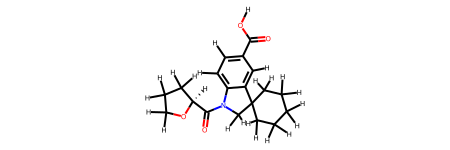

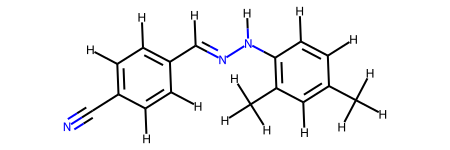

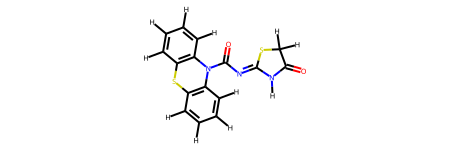

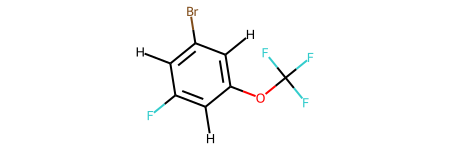

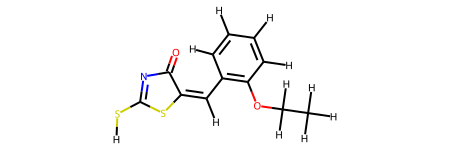

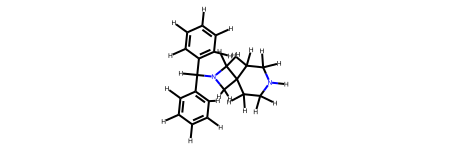

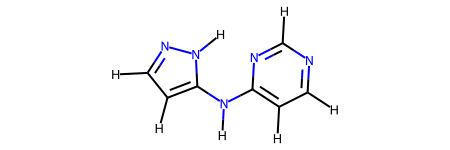

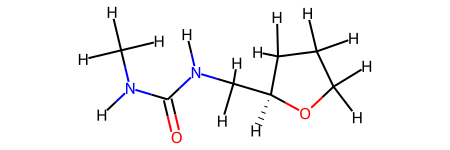

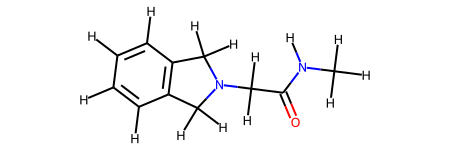

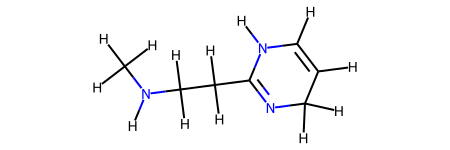

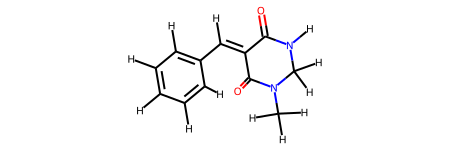

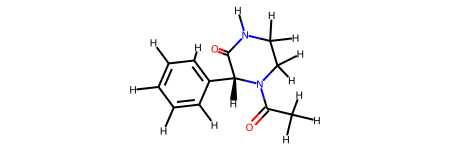

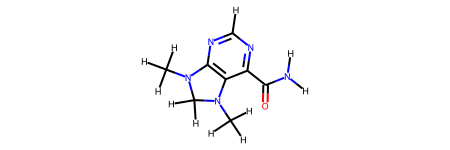

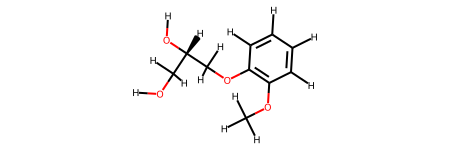

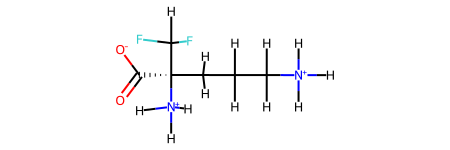

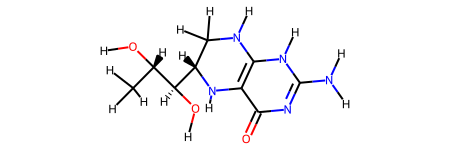

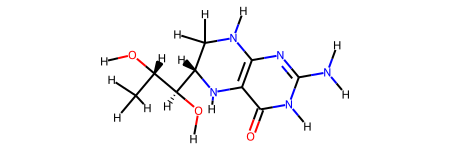

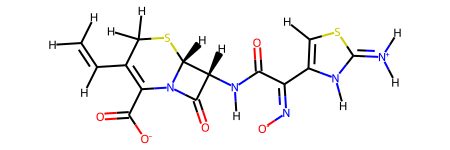

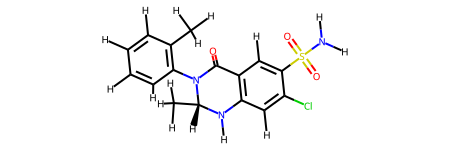

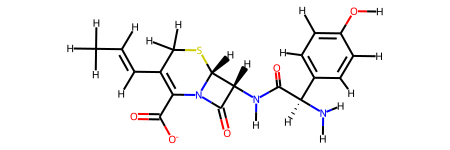

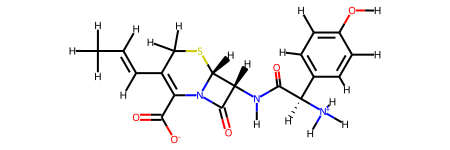

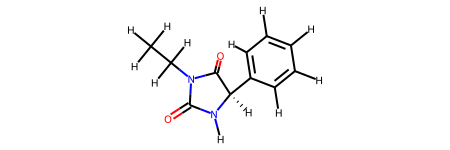

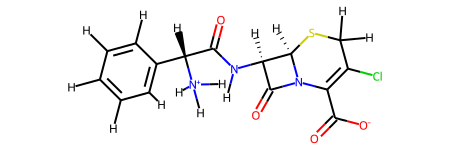

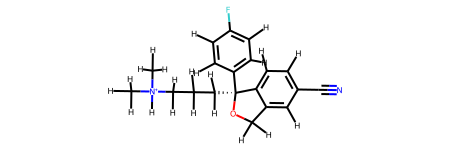

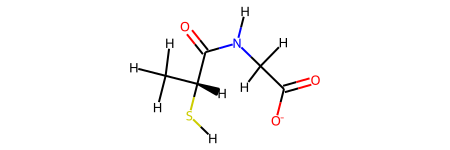

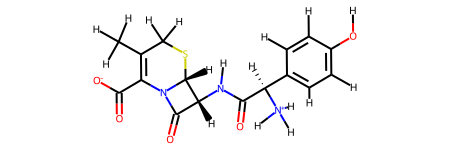

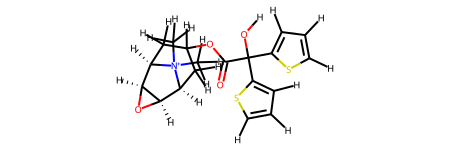

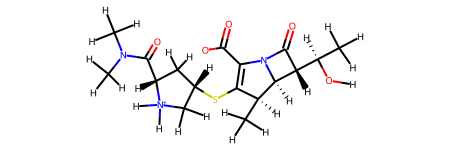

In [6]:
print('Large dde, dde > 5 kcal/mol: ', len(large_dde_mols), 'mols')
for mol in large_dde_mols:
    display(mol)

print('Large RMSD, rmsd > 1 Angstrom ', len(large_rmsd_mols), 'mols')
for mol in large_rmsd_mols:
    display(mol)

print('Large TFD, tfd > 0.1 ', len(large_tfd_mols), 'mols')
for mol in large_tfd_mols:
    display(mol)

# Over-representation of parameters

It is defined as the ratio of (fraction of mols a parameter is matched to in the subset) to (fraction of mols the same parameter is matched to on the whole set). 

Subset here refers to the set of large discrepancy molecules. 

So, any parameter having a value greater than 1 is heavily represented in the large discrepancy set and the higher the value the parameter is overrepresented.

# Large dde

t98 0.22092857142857142
t101 0.23806958128078817
t96 0.29694700460829493
t88 0.4184253246753247
t102 0.5875759878419453
t112 0.5875759878419453
t51 0.5888288151081328
t70 0.6205858747993579
t86 0.638521882741536
t130 0.8043515950069349
t81 0.8122373949579831
t15 0.9522783251231527
t118 0.9862882653061223
t16 1.0228174603174602
t77 1.0318689422671723
t128 1.0603029169783096
t17 1.0627089369289058
t71 1.0637301587301589
t44 1.0877713022508038
t59 1.1271865889212829
t73 1.1506696428571428
t74 1.1541044776119402
t3 1.1734874544718739
t47 1.1751519756838906
t109 1.1751519756838906
t66 1.2006987577639752
t4 1.2297572949799473
t1 1.263351373430001
t67 1.284468438538206
t20 1.2913990236382322
t100 1.2919799498746867
t72 1.299579831932773
t108 1.299579831932773
t69 1.3409928463039236
t62 1.351520624563039
t2 1.3595604395604395
t46 1.3693919716646987
t18 1.3963182182985554
t99 1.4308845299777944
t70d 1.4534774436090223
t9 1.4689399696048633
t87 1.4847350230414746
t52 1.489663604030824
t140 1.492

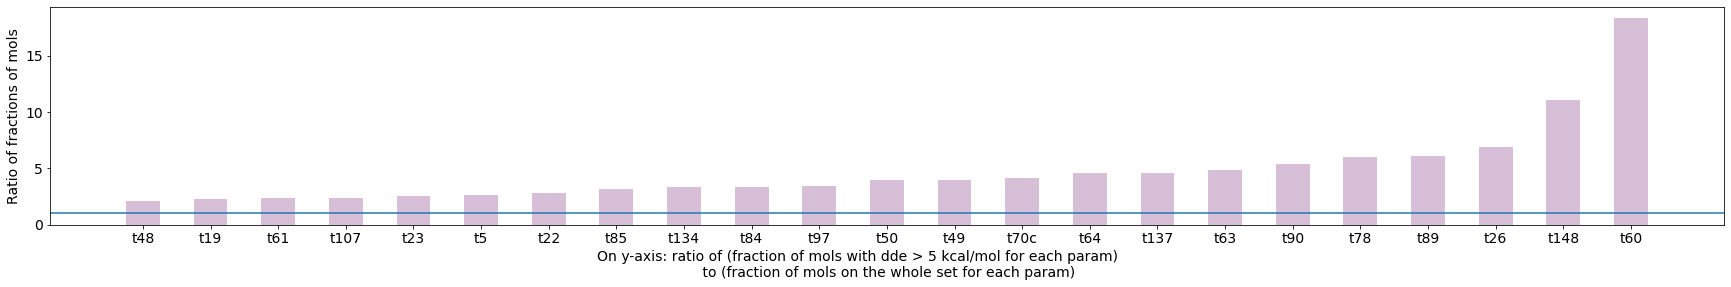

None

In [7]:
off130_parameter_representation={}
plt.figure(figsize=(30, 4))  # width:20, height:3
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
for key, value in params_dde_subset.items():
    off130_parameter_representation[key] = params_dde_subset[key]/params_full[key]

# plotting only values greater than 2 for clarity
for key, value in sorted(off130_parameter_representation.items(), key=lambda item: item[1]):
    print(key, off130_parameter_representation[key])
    if value > 2.0:
        plt.bar(key, off130_parameter_representation[key], align='center', width=0.5, color='thistle')
plt.xlabel("On y-axis: ratio of (fraction of mols with dde > 5 kcal/mol for each param) \
            \n to (fraction of mols on the whole set for each param)", fontsize=14)
plt.ylabel("Ratio of fractions of mols", fontsize=14)
plt.axhline(y=1)
display(plt.show())

# Large RMSD

t99 0.28617690599555884
t100 0.32299498746867167
t70d 0.3633693609022556
t70 0.41372391653290524
t101 0.47613916256157635
t76 0.5595151953690304
t24 0.5635932944606413
t2 0.5948076923076923
t75 0.6102999210734017
t98 0.6627857142857143
t5 0.6654475043029259
t69 0.7543084760459571
t128 0.7711293941660434
t85 0.7966174450549451
t108 0.8663865546218487
t9 0.8813639817629181
t96 0.8908410138248848
t157 0.9577828241123039
t47 1.0119364235055726
t88 1.0460633116883118
t4 1.0693541695477804
t44 1.0877713022508038
t77 1.1404867256637168
t52 1.1458950800237109
t74 1.1541044776119402
t102 1.1751519756838906
t86 1.2131915772089183
t3 1.2517199514366653
t67 1.284468438538206
t51 1.2954233932378922
t1 1.3028311038496887
t17 1.321205705371072
t69a 1.3944995491433725
t84 1.4018310369833213
t87 1.4847350230414746
t59 1.578061224489796
t62 1.6218247494756468
t71 1.6365079365079365
t20 1.639083376156218
t97 1.6951041286079649
t18 1.7066111556982344
t70b 1.7461076776800573
t112 1.762727963525836
t73 1.97

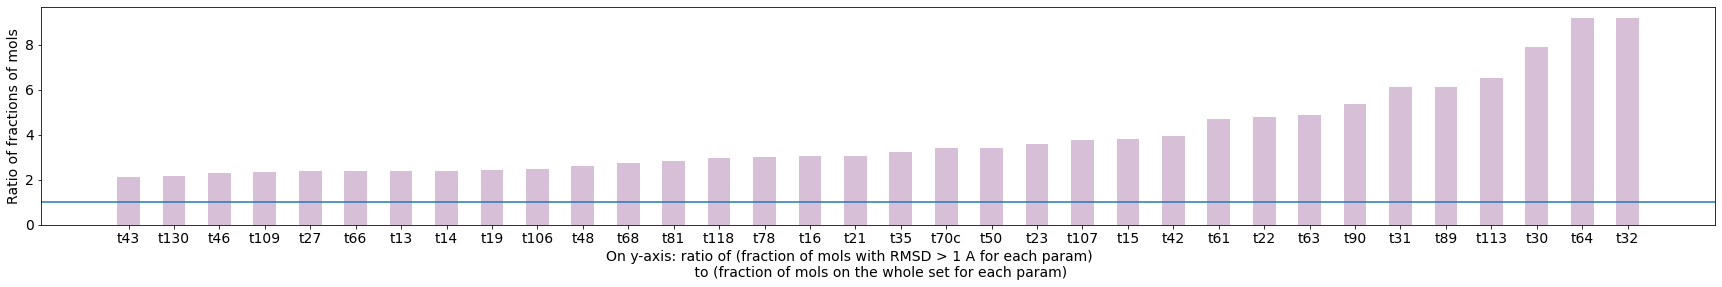

None

In [8]:
off130_parameter_representation={}
plt.figure(figsize=(30, 4))  # width:20, height:3
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
for key, value in params_rmsd_subset.items():
    off130_parameter_representation[key] = params_rmsd_subset[key]/params_full[key]

# plotting only values greater than 2 for clarity
for key, value in sorted(off130_parameter_representation.items(), key=lambda item: item[1]):
    print(key, off130_parameter_representation[key])
    if value > 2.0:
        plt.bar(key, off130_parameter_representation[key], align='center', width=0.5, color='thistle')
plt.xlabel("On y-axis: ratio of (fraction of mols with RMSD > 1 A for each param) \
            \n to (fraction of mols on the whole set for each param)", fontsize=14)
plt.ylabel("Ratio of fractions of mols", fontsize=14)
plt.axhline(y=1)
display(plt.show())

# Large TFD

t27 0.3279957582184517
t101 0.4227186711522288
t98 0.45263414634146343
t108 0.5029268292682927
t157 0.5232764697589173
t42 0.5388501742160279
t128 0.5397905759162305
t129 0.5453423449897149
t16 0.5588075880758807
t47 0.575155682407888
t125 0.5803001876172609
t70 0.5933406412715811
t69 0.5952699951885709
t76 0.611372701281282
t75 0.6147655302519875
t24 0.6158287705326032
t130 0.6225550556476439
t64 0.6286585365853659
t70b 0.6401647660403393
t15 0.6503364171572751
t118 0.6735627177700348
t77 0.675019785596086
t43 0.6895706068578054
t67 0.7017583664208735
t97 0.7138731208283949
t81 0.7211083213773314
t69a 0.7346631771096791
t46 0.7481556137875428
t68 0.7647243568326094
t70d 0.7940949935815147
t136 0.8082752613240418
t50 0.8262369337979094
t62 0.8491505192376557
t74 0.8669858026938478
t9 0.8961728074727556
t48 0.9052682926829269
t85 0.90671904315197
t45 0.9092752684421634
t2 0.916874296435272
t44 0.9217629989804721
t59 0.923743155798905
t71 0.9387967479674796
t139 0.9429878048780487
t141 0

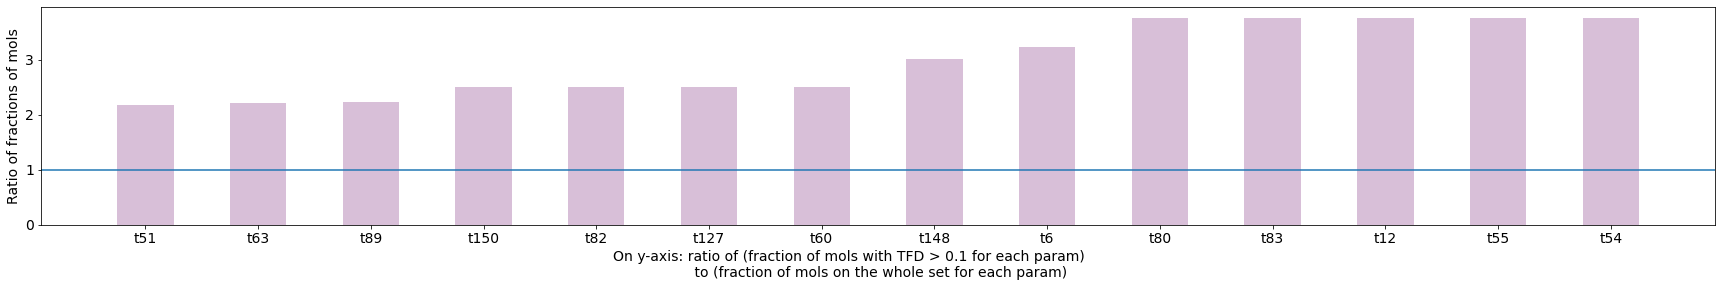

None

In [9]:
off130_parameter_representation={}
plt.figure(figsize=(30, 4))  # width:20, height:3
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
for key, value in params_tfd_subset.items():
    off130_parameter_representation[key] = params_tfd_subset[key]/params_full[key]

# plotting only values greater than 2 for clarity
for key, value in sorted(off130_parameter_representation.items(), key=lambda item: item[1]):
    print(key, off130_parameter_representation[key])
    if value > 2.0:
        plt.bar(key, off130_parameter_representation[key], align='center', width=0.5, color='thistle')
plt.xlabel("On y-axis: ratio of (fraction of mols with TFD > 0.1 for each param) \
            \n to (fraction of mols on the whole set for each param)", fontsize=14)
plt.ylabel("Ratio of fractions of mols", fontsize=14)
plt.axhline(y=1)
display(plt.show())